# Predict climate from berry fungal communities

> using `ritme` (https://github.com/adamovanja/ritme)

note. use the **ritme_model** environment! 


In [62]:
from ritme.find_best_model_config import (
    _load_experiment_config,
    _load_phylogeny,
    _load_taxonomy,
    find_best_model_config,
)
from ritme.split_train_test import _load_data, split_train_test
from ritme.evaluate_tuned_models import evaluate_tuned_models

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mlflow
import numpy as np

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
workdir = '/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/climate-berries'
%cd $workdir

/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/climate-berries


In [3]:
# set experiment configuration path - this is downloaded from the github repo
# here we specify the column to be stratified by and the target! 
model_config_path = "/home/lfloerl/microterroir/Microbiome/Other_scripts/config/r_local_linreg_py.json"

# define path to feature table, metadata, and taxonomy (no phylogeny)
path_to_ft = "climate_filtered_table.qza"
path_to_md = "/home/lfloerl/microterroir/Microbiome/Metadata/ITS_Lavaux_Climate.tsv"
path_to_tax = "/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/taxonomy.qza"

# define train size
train_size = 0.8

In [4]:
config = _load_experiment_config(model_config_path)

## Read & split data


In [5]:
md, ft = _load_data(path_to_md, path_to_ft)
print(md.shape, ft.shape)

(595, 36) (326, 6091)


In [6]:
train_val, test = split_train_test(
    md,
    ft,
    stratify_by_column=config["stratify_by_column"],
    feature_prefix=config["feature_prefix"],
    train_size=train_size,
    seed=config["seed_data"],
)

Train: (96, 6127), Test: (230, 6127)


/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/ritme/split_train_test.py:135: UserWarning: Provided feature table contains absolute instead of relative abundances. Hence, converting it to relative abundances...
  warnings.warn(


## Find best model config

View the results with navigating to the folder in the terminal (e.g. `cd /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/climate-berries/ritme_all_models`) and launching  mlflow (`mlflow ui --port 8080`) and opening _http://localhost:8080_ 

In [7]:
tax = _load_taxonomy(path_to_tax)

best_model_dict, path_to_exp = find_best_model_config(
    config, train_val, tax, path_store_model_logs="ritme_linreg_xgb_rf")

(train_rf pid=227587) Train: (48, 57), Test: (48, 57)


2025-02-17 12:52:38,037	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.266 s, which may be a performance bottleneck.
2025-02-17 12:52:38,039	WARNING util.py:201 -- The `process_trial_result` operation took 1.268 s, which may be a performance bottleneck.
2025-02-17 12:52:38,040	WARNING util.py:201 -- Processing trial results took 1.269 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:52:38,040	WARNING util.py:201 -- The `process_trial_result` operation took 1.269 s, which may be a performance bottleneck.


(train_rf pid=227645) Train: (48, 690), Test: (48, 690)


2025-02-17 12:52:44,098	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.384 s, which may be a performance bottleneck.
2025-02-17 12:52:44,100	WARNING util.py:201 -- The `process_trial_result` operation took 1.386 s, which may be a performance bottleneck.
2025-02-17 12:52:44,101	WARNING util.py:201 -- Processing trial results took 1.387 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:52:44,101	WARNING util.py:201 -- The `process_trial_result` operation took 1.387 s, which may be a performance bottleneck.


(train_rf pid=227705) Train: (48, 46), Test: (48, 46)


2025-02-17 12:52:49,930	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.520 s, which may be a performance bottleneck.
2025-02-17 12:52:49,932	WARNING util.py:201 -- The `process_trial_result` operation took 1.522 s, which may be a performance bottleneck.
2025-02-17 12:52:49,932	WARNING util.py:201 -- Processing trial results took 1.523 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:52:49,933	WARNING util.py:201 -- The `process_trial_result` operation took 1.524 s, which may be a performance bottleneck.


(train_rf pid=227760) Train: (48, 1263), Test: (48, 1263)


2025-02-17 12:52:55,685	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.350 s, which may be a performance bottleneck.
2025-02-17 12:52:55,687	WARNING util.py:201 -- The `process_trial_result` operation took 1.352 s, which may be a performance bottleneck.
2025-02-17 12:52:55,687	WARNING util.py:201 -- Processing trial results took 1.352 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:52:55,688	WARNING util.py:201 -- The `process_trial_result` operation took 1.353 s, which may be a performance bottleneck.


(train_rf pid=227816) Train: (48, 1318), Test: (48, 1318)


2025-02-17 12:53:01,240	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.332 s, which may be a performance bottleneck.
2025-02-17 12:53:01,241	WARNING util.py:201 -- The `process_trial_result` operation took 1.333 s, which may be a performance bottleneck.
2025-02-17 12:53:01,242	WARNING util.py:201 -- Processing trial results took 1.335 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:53:01,243	WARNING util.py:201 -- The `process_trial_result` operation took 1.335 s, which may be a performance bottleneck.


(train_rf pid=228021) Train: (48, 39), Test: (48, 39)


2025-02-17 12:53:06,937	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.302 s, which may be a performance bottleneck.
2025-02-17 12:53:06,938	WARNING util.py:201 -- The `process_trial_result` operation took 1.304 s, which may be a performance bottleneck.
2025-02-17 12:53:06,939	WARNING util.py:201 -- Processing trial results took 1.305 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:53:06,939	WARNING util.py:201 -- The `process_trial_result` operation took 1.305 s, which may be a performance bottleneck.


(train_rf pid=228284) Train: (48, 312), Test: (48, 312)


2025-02-17 12:53:12,887	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.340 s, which may be a performance bottleneck.
2025-02-17 12:53:12,888	WARNING util.py:201 -- The `process_trial_result` operation took 1.342 s, which may be a performance bottleneck.
2025-02-17 12:53:12,889	WARNING util.py:201 -- Processing trial results took 1.342 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:53:12,889	WARNING util.py:201 -- The `process_trial_result` operation took 1.343 s, which may be a performance bottleneck.


(train_rf pid=228364) Train: (48, 726), Test: (48, 726)


2025-02-17 12:53:19,385	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.587 s, which may be a performance bottleneck.
2025-02-17 12:53:19,387	WARNING util.py:201 -- The `process_trial_result` operation took 1.590 s, which may be a performance bottleneck.
2025-02-17 12:53:19,388	WARNING util.py:201 -- Processing trial results took 1.590 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:53:19,388	WARNING util.py:201 -- The `process_trial_result` operation took 1.591 s, which may be a performance bottleneck.


(train_rf pid=228428) Train: (48, 312), Test: (48, 312)


2025-02-17 12:53:25,133	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.459 s, which may be a performance bottleneck.
2025-02-17 12:53:25,135	WARNING util.py:201 -- The `process_trial_result` operation took 1.461 s, which may be a performance bottleneck.
2025-02-17 12:53:25,135	WARNING util.py:201 -- Processing trial results took 1.462 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:53:25,136	WARNING util.py:201 -- The `process_trial_result` operation took 1.462 s, which may be a performance bottleneck.


(train_rf pid=228487) Train: (48, 1203), Test: (48, 1203)


2025-02-17 12:53:30,906	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.337 s, which may be a performance bottleneck.
2025-02-17 12:53:30,907	WARNING util.py:201 -- The `process_trial_result` operation took 1.339 s, which may be a performance bottleneck.
2025-02-17 12:53:30,908	WARNING util.py:201 -- Processing trial results took 1.339 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:53:30,908	WARNING util.py:201 -- The `process_trial_result` operation took 1.340 s, which may be a performance bottleneck.


(train_rf pid=228545) Train: (48, 40), Test: (48, 40)


2025-02-17 12:53:36,294	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.341 s, which may be a performance bottleneck.
2025-02-17 12:53:36,295	WARNING util.py:201 -- The `process_trial_result` operation took 1.343 s, which may be a performance bottleneck.
2025-02-17 12:53:36,296	WARNING util.py:201 -- Processing trial results took 1.343 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:53:36,297	WARNING util.py:201 -- The `process_trial_result` operation took 1.344 s, which may be a performance bottleneck.


(train_rf pid=228604) Train: (48, 104), Test: (48, 104)


2025-02-17 12:53:42,062	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.358 s, which may be a performance bottleneck.
2025-02-17 12:53:42,064	WARNING util.py:201 -- The `process_trial_result` operation took 1.360 s, which may be a performance bottleneck.
2025-02-17 12:53:42,065	WARNING util.py:201 -- Processing trial results took 1.361 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:53:42,065	WARNING util.py:201 -- The `process_trial_result` operation took 1.362 s, which may be a performance bottleneck.


(train_rf pid=228666) Train: (48, 38), Test: (48, 38)


2025-02-17 12:53:47,844	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.354 s, which may be a performance bottleneck.
2025-02-17 12:53:47,845	WARNING util.py:201 -- The `process_trial_result` operation took 1.356 s, which may be a performance bottleneck.
2025-02-17 12:53:47,847	WARNING util.py:201 -- Processing trial results took 1.358 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:53:47,847	WARNING util.py:201 -- The `process_trial_result` operation took 1.358 s, which may be a performance bottleneck.


(train_rf pid=228726) Train: (48, 38), Test: (48, 38)


2025-02-17 12:53:53,825	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.427 s, which may be a performance bottleneck.
2025-02-17 12:53:53,827	WARNING util.py:201 -- The `process_trial_result` operation took 1.429 s, which may be a performance bottleneck.
2025-02-17 12:53:53,827	WARNING util.py:201 -- Processing trial results took 1.430 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:53:53,828	WARNING util.py:201 -- The `process_trial_result` operation took 1.430 s, which may be a performance bottleneck.


(train_rf pid=228786) Train: (48, 1058), Test: (48, 1058)


2025-02-17 12:53:59,586	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.399 s, which may be a performance bottleneck.
2025-02-17 12:53:59,588	WARNING util.py:201 -- The `process_trial_result` operation took 1.401 s, which may be a performance bottleneck.
2025-02-17 12:53:59,590	WARNING util.py:201 -- Processing trial results took 1.403 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:53:59,590	WARNING util.py:201 -- The `process_trial_result` operation took 1.403 s, which may be a performance bottleneck.


(train_rf pid=228844) Train: (48, 1058), Test: (48, 1058)


2025-02-17 12:54:05,776	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.322 s, which may be a performance bottleneck.
2025-02-17 12:54:05,777	WARNING util.py:201 -- The `process_trial_result` operation took 1.323 s, which may be a performance bottleneck.
2025-02-17 12:54:05,778	WARNING util.py:201 -- Processing trial results took 1.324 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:54:05,778	WARNING util.py:201 -- The `process_trial_result` operation took 1.324 s, which may be a performance bottleneck.


(train_rf pid=228929) Train: (48, 990), Test: (48, 990)


2025-02-17 12:54:11,675	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.374 s, which may be a performance bottleneck.
2025-02-17 12:54:11,677	WARNING util.py:201 -- The `process_trial_result` operation took 1.376 s, which may be a performance bottleneck.
2025-02-17 12:54:11,678	WARNING util.py:201 -- Processing trial results took 1.377 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:54:11,678	WARNING util.py:201 -- The `process_trial_result` operation took 1.378 s, which may be a performance bottleneck.


(train_rf pid=228987) Train: (48, 1304), Test: (48, 1304)


2025-02-17 12:54:17,464	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.314 s, which may be a performance bottleneck.
2025-02-17 12:54:17,465	WARNING util.py:201 -- The `process_trial_result` operation took 1.316 s, which may be a performance bottleneck.
2025-02-17 12:54:17,466	WARNING util.py:201 -- Processing trial results took 1.316 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:54:17,467	WARNING util.py:201 -- The `process_trial_result` operation took 1.317 s, which may be a performance bottleneck.


(train_rf pid=229050) Train: (48, 1318), Test: (48, 1318)


2025-02-17 12:54:23,545	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.514 s, which may be a performance bottleneck.
2025-02-17 12:54:23,547	WARNING util.py:201 -- The `process_trial_result` operation took 1.516 s, which may be a performance bottleneck.
2025-02-17 12:54:23,547	WARNING util.py:201 -- Processing trial results took 1.516 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:54:23,547	WARNING util.py:201 -- The `process_trial_result` operation took 1.517 s, which may be a performance bottleneck.


(train_rf pid=229104) Train: (48, 1199), Test: (48, 1199)


2025-02-17 12:54:29,049	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.408 s, which may be a performance bottleneck.
2025-02-17 12:54:29,051	WARNING util.py:201 -- The `process_trial_result` operation took 1.410 s, which may be a performance bottleneck.
2025-02-17 12:54:29,051	WARNING util.py:201 -- Processing trial results took 1.410 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:54:29,051	WARNING util.py:201 -- The `process_trial_result` operation took 1.410 s, which may be a performance bottleneck.


(train_rf pid=229159) Train: (48, 1199), Test: (48, 1199)


2025-02-17 12:54:34,734	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.309 s, which may be a performance bottleneck.
2025-02-17 12:54:34,736	WARNING util.py:201 -- The `process_trial_result` operation took 1.310 s, which may be a performance bottleneck.
2025-02-17 12:54:34,737	WARNING util.py:201 -- Processing trial results took 1.311 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:54:34,737	WARNING util.py:201 -- The `process_trial_result` operation took 1.311 s, which may be a performance bottleneck.


(train_rf pid=229255) Train: (48, 1058), Test: (48, 1058)


2025-02-17 12:54:40,705	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.344 s, which may be a performance bottleneck.
2025-02-17 12:54:40,707	WARNING util.py:201 -- The `process_trial_result` operation took 1.346 s, which may be a performance bottleneck.
2025-02-17 12:54:40,707	WARNING util.py:201 -- Processing trial results took 1.347 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:54:40,708	WARNING util.py:201 -- The `process_trial_result` operation took 1.347 s, which may be a performance bottleneck.


(train_rf pid=229314) Train: (48, 1058), Test: (48, 1058)


2025-02-17 12:54:46,801	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.662 s, which may be a performance bottleneck.
2025-02-17 12:54:46,802	WARNING util.py:201 -- The `process_trial_result` operation took 1.664 s, which may be a performance bottleneck.
2025-02-17 12:54:46,803	WARNING util.py:201 -- Processing trial results took 1.664 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:54:46,803	WARNING util.py:201 -- The `process_trial_result` operation took 1.665 s, which may be a performance bottleneck.


(train_rf pid=229377) Train: (48, 1199), Test: (48, 1199)


2025-02-17 12:54:52,438	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.437 s, which may be a performance bottleneck.
2025-02-17 12:54:52,439	WARNING util.py:201 -- The `process_trial_result` operation took 1.439 s, which may be a performance bottleneck.
2025-02-17 12:54:52,440	WARNING util.py:201 -- Processing trial results took 1.440 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:54:52,441	WARNING util.py:201 -- The `process_trial_result` operation took 1.440 s, which may be a performance bottleneck.


(train_rf pid=229435) Train: (48, 1203), Test: (48, 1203)


2025-02-17 12:54:58,674	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.550 s, which may be a performance bottleneck.
2025-02-17 12:54:58,676	WARNING util.py:201 -- The `process_trial_result` operation took 1.552 s, which may be a performance bottleneck.
2025-02-17 12:54:58,677	WARNING util.py:201 -- Processing trial results took 1.553 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:54:58,677	WARNING util.py:201 -- The `process_trial_result` operation took 1.554 s, which may be a performance bottleneck.


(train_rf pid=229492) Train: (48, 1203), Test: (48, 1203)


2025-02-17 12:55:04,479	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.375 s, which may be a performance bottleneck.
2025-02-17 12:55:04,481	WARNING util.py:201 -- The `process_trial_result` operation took 1.376 s, which may be a performance bottleneck.
2025-02-17 12:55:04,482	WARNING util.py:201 -- Processing trial results took 1.377 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:55:04,483	WARNING util.py:201 -- The `process_trial_result` operation took 1.378 s, which may be a performance bottleneck.


(train_rf pid=229576) Train: (48, 1203), Test: (48, 1203)


2025-02-17 12:55:10,243	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.380 s, which may be a performance bottleneck.
2025-02-17 12:55:10,245	WARNING util.py:201 -- The `process_trial_result` operation took 1.382 s, which may be a performance bottleneck.
2025-02-17 12:55:10,246	WARNING util.py:201 -- Processing trial results took 1.383 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:55:10,246	WARNING util.py:201 -- The `process_trial_result` operation took 1.383 s, which may be a performance bottleneck.


(train_rf pid=229631) Train: (48, 833), Test: (48, 833)


2025-02-17 12:55:15,922	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.249 s, which may be a performance bottleneck.
2025-02-17 12:55:15,924	WARNING util.py:201 -- The `process_trial_result` operation took 1.251 s, which may be a performance bottleneck.
2025-02-17 12:55:15,925	WARNING util.py:201 -- Processing trial results took 1.252 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:55:15,925	WARNING util.py:201 -- The `process_trial_result` operation took 1.252 s, which may be a performance bottleneck.


(train_rf pid=229693) Train: (48, 38), Test: (48, 38)


2025-02-17 12:55:22,068	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.407 s, which may be a performance bottleneck.
2025-02-17 12:55:22,070	WARNING util.py:201 -- The `process_trial_result` operation took 1.409 s, which may be a performance bottleneck.
2025-02-17 12:55:22,070	WARNING util.py:201 -- Processing trial results took 1.410 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:55:22,071	WARNING util.py:201 -- The `process_trial_result` operation took 1.410 s, which may be a performance bottleneck.


(train_rf pid=229753) Train: (48, 90), Test: (48, 90)


2025-02-17 12:55:28,185	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.767 s, which may be a performance bottleneck.
2025-02-17 12:55:28,187	WARNING util.py:201 -- The `process_trial_result` operation took 1.769 s, which may be a performance bottleneck.
2025-02-17 12:55:28,187	WARNING util.py:201 -- Processing trial results took 1.770 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:55:28,188	WARNING util.py:201 -- The `process_trial_result` operation took 1.770 s, which may be a performance bottleneck.


(train_rf pid=229813) Train: (48, 101), Test: (48, 101)


2025-02-17 12:55:33,459	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.244 s, which may be a performance bottleneck.
2025-02-17 12:55:33,461	WARNING util.py:201 -- The `process_trial_result` operation took 1.246 s, which may be a performance bottleneck.
2025-02-17 12:55:33,461	WARNING util.py:201 -- Processing trial results took 1.246 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:55:33,461	WARNING util.py:201 -- The `process_trial_result` operation took 1.246 s, which may be a performance bottleneck.


(train_rf pid=229871) Train: (48, 833), Test: (48, 833)


2025-02-17 12:55:39,771	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.221 s, which may be a performance bottleneck.
2025-02-17 12:55:39,772	WARNING util.py:201 -- The `process_trial_result` operation took 1.223 s, which may be a performance bottleneck.
2025-02-17 12:55:39,773	WARNING util.py:201 -- Processing trial results took 1.224 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:55:39,773	WARNING util.py:201 -- The `process_trial_result` operation took 1.224 s, which may be a performance bottleneck.


(train_rf pid=229930) Train: (48, 734), Test: (48, 734)


2025-02-17 12:55:45,658	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.219 s, which may be a performance bottleneck.
2025-02-17 12:55:45,660	WARNING util.py:201 -- The `process_trial_result` operation took 1.222 s, which may be a performance bottleneck.
2025-02-17 12:55:45,661	WARNING util.py:201 -- Processing trial results took 1.222 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:55:45,661	WARNING util.py:201 -- The `process_trial_result` operation took 1.223 s, which may be a performance bottleneck.


(train_rf pid=229993) Train: (48, 833), Test: (48, 833)


2025-02-17 12:55:51,558	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.269 s, which may be a performance bottleneck.
2025-02-17 12:55:51,560	WARNING util.py:201 -- The `process_trial_result` operation took 1.271 s, which may be a performance bottleneck.
2025-02-17 12:55:51,560	WARNING util.py:201 -- Processing trial results took 1.271 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:55:51,561	WARNING util.py:201 -- The `process_trial_result` operation took 1.272 s, which may be a performance bottleneck.


(train_rf pid=230052) Train: (48, 858), Test: (48, 858)


2025-02-17 12:55:57,399	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.305 s, which may be a performance bottleneck.
2025-02-17 12:55:57,401	WARNING util.py:201 -- The `process_trial_result` operation took 1.307 s, which may be a performance bottleneck.
2025-02-17 12:55:57,402	WARNING util.py:201 -- Processing trial results took 1.308 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:55:57,403	WARNING util.py:201 -- The `process_trial_result` operation took 1.309 s, which may be a performance bottleneck.


(train_rf pid=230115) Train: (48, 1078), Test: (48, 1078)


2025-02-17 12:56:03,246	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.264 s, which may be a performance bottleneck.
2025-02-17 12:56:03,248	WARNING util.py:201 -- The `process_trial_result` operation took 1.266 s, which may be a performance bottleneck.
2025-02-17 12:56:03,249	WARNING util.py:201 -- Processing trial results took 1.267 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:56:03,249	WARNING util.py:201 -- The `process_trial_result` operation took 1.267 s, which may be a performance bottleneck.


(train_rf pid=230205) Train: (48, 1199), Test: (48, 1199)


2025-02-17 12:56:09,624	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.864 s, which may be a performance bottleneck.
2025-02-17 12:56:09,625	WARNING util.py:201 -- The `process_trial_result` operation took 1.866 s, which may be a performance bottleneck.
2025-02-17 12:56:09,626	WARNING util.py:201 -- Processing trial results took 1.867 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:56:09,626	WARNING util.py:201 -- The `process_trial_result` operation took 1.867 s, which may be a performance bottleneck.


(train_rf pid=230264) Train: (48, 1263), Test: (48, 1263)


2025-02-17 12:56:14,736	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.223 s, which may be a performance bottleneck.
2025-02-17 12:56:14,737	WARNING util.py:201 -- The `process_trial_result` operation took 1.225 s, which may be a performance bottleneck.
2025-02-17 12:56:14,738	WARNING util.py:201 -- Processing trial results took 1.226 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:56:14,739	WARNING util.py:201 -- The `process_trial_result` operation took 1.226 s, which may be a performance bottleneck.


(train_rf pid=230328) Train: (48, 1263), Test: (48, 1263)


2025-02-17 12:56:21,572	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.343 s, which may be a performance bottleneck.
2025-02-17 12:56:21,573	WARNING util.py:201 -- The `process_trial_result` operation took 1.345 s, which may be a performance bottleneck.
2025-02-17 12:56:21,574	WARNING util.py:201 -- Processing trial results took 1.346 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:56:21,575	WARNING util.py:201 -- The `process_trial_result` operation took 1.347 s, which may be a performance bottleneck.


(train_rf pid=230387) Train: (48, 690), Test: (48, 690)


2025-02-17 12:56:27,595	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.455 s, which may be a performance bottleneck.
2025-02-17 12:56:27,597	WARNING util.py:201 -- The `process_trial_result` operation took 1.457 s, which may be a performance bottleneck.
2025-02-17 12:56:27,597	WARNING util.py:201 -- Processing trial results took 1.458 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:56:27,598	WARNING util.py:201 -- The `process_trial_result` operation took 1.458 s, which may be a performance bottleneck.


(train_rf pid=230450) Train: (48, 690), Test: (48, 690)


2025-02-17 12:56:33,571	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.270 s, which may be a performance bottleneck.
2025-02-17 12:56:33,573	WARNING util.py:201 -- The `process_trial_result` operation took 1.272 s, which may be a performance bottleneck.
2025-02-17 12:56:33,574	WARNING util.py:201 -- Processing trial results took 1.273 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:56:33,575	WARNING util.py:201 -- The `process_trial_result` operation took 1.273 s, which may be a performance bottleneck.


(train_rf pid=230509) Train: (48, 46), Test: (48, 46)


2025-02-17 12:56:40,473	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 2.233 s, which may be a performance bottleneck.
2025-02-17 12:56:40,475	WARNING util.py:201 -- The `process_trial_result` operation took 2.235 s, which may be a performance bottleneck.
2025-02-17 12:56:40,476	WARNING util.py:201 -- Processing trial results took 2.236 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:56:40,476	WARNING util.py:201 -- The `process_trial_result` operation took 2.237 s, which may be a performance bottleneck.


(train_rf pid=230568) Train: (48, 1199), Test: (48, 1199)


2025-02-17 12:56:45,386	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.284 s, which may be a performance bottleneck.
2025-02-17 12:56:45,388	WARNING util.py:201 -- The `process_trial_result` operation took 1.286 s, which may be a performance bottleneck.
2025-02-17 12:56:45,388	WARNING util.py:201 -- Processing trial results took 1.287 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:56:45,389	WARNING util.py:201 -- The `process_trial_result` operation took 1.287 s, which may be a performance bottleneck.


(train_rf pid=230626) Train: (48, 1199), Test: (48, 1199)


2025-02-17 12:56:51,934	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.268 s, which may be a performance bottleneck.
2025-02-17 12:56:51,936	WARNING util.py:201 -- The `process_trial_result` operation took 1.270 s, which may be a performance bottleneck.
2025-02-17 12:56:51,937	WARNING util.py:201 -- Processing trial results took 1.271 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:56:51,937	WARNING util.py:201 -- The `process_trial_result` operation took 1.271 s, which may be a performance bottleneck.


(train_rf pid=230685) Train: (48, 1199), Test: (48, 1199)


2025-02-17 12:56:57,653	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.263 s, which may be a performance bottleneck.
2025-02-17 12:56:57,654	WARNING util.py:201 -- The `process_trial_result` operation took 1.264 s, which may be a performance bottleneck.
2025-02-17 12:56:57,655	WARNING util.py:201 -- Processing trial results took 1.265 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:56:57,655	WARNING util.py:201 -- The `process_trial_result` operation took 1.265 s, which may be a performance bottleneck.


(train_rf pid=230749) Train: (48, 1240), Test: (48, 1240)


2025-02-17 12:57:03,650	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.496 s, which may be a performance bottleneck.
2025-02-17 12:57:03,652	WARNING util.py:201 -- The `process_trial_result` operation took 1.498 s, which may be a performance bottleneck.
2025-02-17 12:57:03,652	WARNING util.py:201 -- Processing trial results took 1.498 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:57:03,652	WARNING util.py:201 -- The `process_trial_result` operation took 1.499 s, which may be a performance bottleneck.


(train_rf pid=230837) Train: (48, 1240), Test: (48, 1240)


2025-02-17 12:57:09,241	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.313 s, which may be a performance bottleneck.
2025-02-17 12:57:09,243	WARNING util.py:201 -- The `process_trial_result` operation took 1.315 s, which may be a performance bottleneck.
2025-02-17 12:57:09,244	WARNING util.py:201 -- Processing trial results took 1.315 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:57:09,244	WARNING util.py:201 -- The `process_trial_result` operation took 1.316 s, which may be a performance bottleneck.


(train_rf pid=230895) Train: (48, 990), Test: (48, 990)


2025-02-17 12:57:15,117	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.334 s, which may be a performance bottleneck.
2025-02-17 12:57:15,118	WARNING util.py:201 -- The `process_trial_result` operation took 1.336 s, which may be a performance bottleneck.
2025-02-17 12:57:15,119	WARNING util.py:201 -- Processing trial results took 1.336 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:57:15,119	WARNING util.py:201 -- The `process_trial_result` operation took 1.337 s, which may be a performance bottleneck.


(train_rf pid=230960) Train: (48, 858), Test: (48, 858)


2025-02-17 12:57:21,966	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 2.344 s, which may be a performance bottleneck.
2025-02-17 12:57:21,968	WARNING util.py:201 -- The `process_trial_result` operation took 2.345 s, which may be a performance bottleneck.
2025-02-17 12:57:21,969	WARNING util.py:201 -- Processing trial results took 2.346 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:57:21,970	WARNING util.py:201 -- The `process_trial_result` operation took 2.347 s, which may be a performance bottleneck.


(train_rf pid=231018) Train: (48, 1078), Test: (48, 1078)


2025-02-17 12:57:27,084	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.406 s, which may be a performance bottleneck.
2025-02-17 12:57:27,086	WARNING util.py:201 -- The `process_trial_result` operation took 1.408 s, which may be a performance bottleneck.
2025-02-17 12:57:27,086	WARNING util.py:201 -- Processing trial results took 1.408 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:57:27,087	WARNING util.py:201 -- The `process_trial_result` operation took 1.409 s, which may be a performance bottleneck.


(train_rf pid=231077) Train: (48, 40), Test: (48, 40)


2025-02-17 12:57:34,534	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.724 s, which may be a performance bottleneck.
2025-02-17 12:57:34,536	WARNING util.py:201 -- The `process_trial_result` operation took 1.726 s, which may be a performance bottleneck.
2025-02-17 12:57:34,537	WARNING util.py:201 -- Processing trial results took 1.726 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:57:34,537	WARNING util.py:201 -- The `process_trial_result` operation took 1.727 s, which may be a performance bottleneck.


(train_rf pid=231178) Train: (48, 40), Test: (48, 40)


2025-02-17 12:57:39,931	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.289 s, which may be a performance bottleneck.
2025-02-17 12:57:39,933	WARNING util.py:201 -- The `process_trial_result` operation took 1.291 s, which may be a performance bottleneck.
2025-02-17 12:57:39,934	WARNING util.py:201 -- Processing trial results took 1.292 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:57:39,934	WARNING util.py:201 -- The `process_trial_result` operation took 1.292 s, which may be a performance bottleneck.


(train_rf pid=231239) Train: (48, 1199), Test: (48, 1199)


2025-02-17 12:57:45,557	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.266 s, which may be a performance bottleneck.
2025-02-17 12:57:45,559	WARNING util.py:201 -- The `process_trial_result` operation took 1.268 s, which may be a performance bottleneck.
2025-02-17 12:57:45,559	WARNING util.py:201 -- Processing trial results took 1.269 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:57:45,559	WARNING util.py:201 -- The `process_trial_result` operation took 1.269 s, which may be a performance bottleneck.


(train_rf pid=231298) Train: (48, 1199), Test: (48, 1199)


2025-02-17 12:57:52,675	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 2.616 s, which may be a performance bottleneck.
2025-02-17 12:57:52,677	WARNING util.py:201 -- The `process_trial_result` operation took 2.618 s, which may be a performance bottleneck.
2025-02-17 12:57:52,678	WARNING util.py:201 -- Processing trial results took 2.619 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:57:52,678	WARNING util.py:201 -- The `process_trial_result` operation took 2.620 s, which may be a performance bottleneck.


(train_rf pid=231356) Train: (48, 1078), Test: (48, 1078)


2025-02-17 12:57:57,162	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.308 s, which may be a performance bottleneck.
2025-02-17 12:57:57,164	WARNING util.py:201 -- The `process_trial_result` operation took 1.310 s, which may be a performance bottleneck.
2025-02-17 12:57:57,164	WARNING util.py:201 -- Processing trial results took 1.310 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:57:57,165	WARNING util.py:201 -- The `process_trial_result` operation took 1.311 s, which may be a performance bottleneck.


(train_rf pid=231416) Train: (48, 1078), Test: (48, 1078)


2025-02-17 12:58:04,053	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 2.393 s, which may be a performance bottleneck.
2025-02-17 12:58:04,055	WARNING util.py:201 -- The `process_trial_result` operation took 2.395 s, which may be a performance bottleneck.
2025-02-17 12:58:04,055	WARNING util.py:201 -- Processing trial results took 2.396 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:58:04,056	WARNING util.py:201 -- The `process_trial_result` operation took 2.396 s, which may be a performance bottleneck.


(train_rf pid=231482) Train: (48, 1240), Test: (48, 1240)


2025-02-17 12:58:08,792	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.307 s, which may be a performance bottleneck.
2025-02-17 12:58:08,793	WARNING util.py:201 -- The `process_trial_result` operation took 1.309 s, which may be a performance bottleneck.
2025-02-17 12:58:08,794	WARNING util.py:201 -- Processing trial results took 1.310 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:58:08,794	WARNING util.py:201 -- The `process_trial_result` operation took 1.310 s, which may be a performance bottleneck.


(train_rf pid=231568) Train: (48, 1240), Test: (48, 1240)


2025-02-17 12:58:15,686	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.355 s, which may be a performance bottleneck.
2025-02-17 12:58:15,687	WARNING util.py:201 -- The `process_trial_result` operation took 1.357 s, which may be a performance bottleneck.
2025-02-17 12:58:15,688	WARNING util.py:201 -- Processing trial results took 1.358 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:58:15,688	WARNING util.py:201 -- The `process_trial_result` operation took 1.358 s, which may be a performance bottleneck.


(train_rf pid=231629) Train: (48, 990), Test: (48, 990)


2025-02-17 12:58:21,572	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.452 s, which may be a performance bottleneck.
2025-02-17 12:58:21,574	WARNING util.py:201 -- The `process_trial_result` operation took 1.454 s, which may be a performance bottleneck.
2025-02-17 12:58:21,574	WARNING util.py:201 -- Processing trial results took 1.455 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:58:21,575	WARNING util.py:201 -- The `process_trial_result` operation took 1.455 s, which may be a performance bottleneck.


(train_rf pid=231684) Train: (48, 990), Test: (48, 990)


2025-02-17 12:58:27,478	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.348 s, which may be a performance bottleneck.
2025-02-17 12:58:27,480	WARNING util.py:201 -- The `process_trial_result` operation took 1.350 s, which may be a performance bottleneck.
2025-02-17 12:58:27,480	WARNING util.py:201 -- Processing trial results took 1.351 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:58:27,481	WARNING util.py:201 -- The `process_trial_result` operation took 1.352 s, which may be a performance bottleneck.


(train_rf pid=231743) Train: (48, 1304), Test: (48, 1304)


2025-02-17 12:58:34,572	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 2.706 s, which may be a performance bottleneck.
2025-02-17 12:58:34,574	WARNING util.py:201 -- The `process_trial_result` operation took 2.708 s, which may be a performance bottleneck.
2025-02-17 12:58:34,574	WARNING util.py:201 -- Processing trial results took 2.708 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:58:34,574	WARNING util.py:201 -- The `process_trial_result` operation took 2.709 s, which may be a performance bottleneck.


(train_rf pid=231805) Train: (48, 312), Test: (48, 312)


2025-02-17 12:58:38,852	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.318 s, which may be a performance bottleneck.
2025-02-17 12:58:38,854	WARNING util.py:201 -- The `process_trial_result` operation took 1.320 s, which may be a performance bottleneck.
2025-02-17 12:58:38,854	WARNING util.py:201 -- Processing trial results took 1.320 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:58:38,854	WARNING util.py:201 -- The `process_trial_result` operation took 1.321 s, which may be a performance bottleneck.


(train_rf pid=231867) Train: (48, 726), Test: (48, 726)


2025-02-17 12:58:46,296	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.311 s, which may be a performance bottleneck.
2025-02-17 12:58:46,298	WARNING util.py:201 -- The `process_trial_result` operation took 1.313 s, which may be a performance bottleneck.
2025-02-17 12:58:46,298	WARNING util.py:201 -- Processing trial results took 1.313 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:58:46,299	WARNING util.py:201 -- The `process_trial_result` operation took 1.314 s, which may be a performance bottleneck.


(train_rf pid=231926) Train: (48, 734), Test: (48, 734)


2025-02-17 12:58:52,087	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.325 s, which may be a performance bottleneck.
2025-02-17 12:58:52,089	WARNING util.py:201 -- The `process_trial_result` operation took 1.328 s, which may be a performance bottleneck.
2025-02-17 12:58:52,090	WARNING util.py:201 -- Processing trial results took 1.328 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:58:52,091	WARNING util.py:201 -- The `process_trial_result` operation took 1.329 s, which may be a performance bottleneck.


(train_rf pid=231984) Train: (48, 1058), Test: (48, 1058)


2025-02-17 12:58:58,260	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.376 s, which may be a performance bottleneck.
2025-02-17 12:58:58,261	WARNING util.py:201 -- The `process_trial_result` operation took 1.377 s, which may be a performance bottleneck.
2025-02-17 12:58:58,262	WARNING util.py:201 -- Processing trial results took 1.378 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:58:58,263	WARNING util.py:201 -- The `process_trial_result` operation took 1.379 s, which may be a performance bottleneck.


(train_rf pid=232044) Train: (48, 1058), Test: (48, 1058)


2025-02-17 12:59:05,296	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 2.732 s, which may be a performance bottleneck.
2025-02-17 12:59:05,298	WARNING util.py:201 -- The `process_trial_result` operation took 2.735 s, which may be a performance bottleneck.
2025-02-17 12:59:05,299	WARNING util.py:201 -- Processing trial results took 2.736 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:59:05,299	WARNING util.py:201 -- The `process_trial_result` operation took 2.736 s, which may be a performance bottleneck.


(train_rf pid=232133) Train: (48, 1203), Test: (48, 1203)


2025-02-17 12:59:09,765	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.366 s, which may be a performance bottleneck.
2025-02-17 12:59:09,767	WARNING util.py:201 -- The `process_trial_result` operation took 1.368 s, which may be a performance bottleneck.
2025-02-17 12:59:09,767	WARNING util.py:201 -- Processing trial results took 1.369 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:59:09,768	WARNING util.py:201 -- The `process_trial_result` operation took 1.369 s, which may be a performance bottleneck.


(train_rf pid=232195) Train: (48, 1203), Test: (48, 1203)


2025-02-17 12:59:17,132	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.334 s, which may be a performance bottleneck.
2025-02-17 12:59:17,133	WARNING util.py:201 -- The `process_trial_result` operation took 1.336 s, which may be a performance bottleneck.
2025-02-17 12:59:17,134	WARNING util.py:201 -- Processing trial results took 1.337 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:59:17,134	WARNING util.py:201 -- The `process_trial_result` operation took 1.337 s, which may be a performance bottleneck.


(train_rf pid=232260) Train: (48, 990), Test: (48, 990)


2025-02-17 12:59:23,014	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.393 s, which may be a performance bottleneck.
2025-02-17 12:59:23,016	WARNING util.py:201 -- The `process_trial_result` operation took 1.394 s, which may be a performance bottleneck.
2025-02-17 12:59:23,016	WARNING util.py:201 -- Processing trial results took 1.395 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:59:23,017	WARNING util.py:201 -- The `process_trial_result` operation took 1.395 s, which may be a performance bottleneck.


(train_rf pid=232318) Train: (48, 990), Test: (48, 990)


2025-02-17 12:59:29,224	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.325 s, which may be a performance bottleneck.
2025-02-17 12:59:29,225	WARNING util.py:201 -- The `process_trial_result` operation took 1.327 s, which may be a performance bottleneck.
2025-02-17 12:59:29,226	WARNING util.py:201 -- Processing trial results took 1.327 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:59:29,226	WARNING util.py:201 -- The `process_trial_result` operation took 1.327 s, which may be a performance bottleneck.


(train_rf pid=232377) Train: (48, 1199), Test: (48, 1199)


2025-02-17 12:59:36,548	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 2.863 s, which may be a performance bottleneck.
2025-02-17 12:59:36,550	WARNING util.py:201 -- The `process_trial_result` operation took 2.865 s, which may be a performance bottleneck.
2025-02-17 12:59:36,550	WARNING util.py:201 -- Processing trial results took 2.865 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:59:36,551	WARNING util.py:201 -- The `process_trial_result` operation took 2.866 s, which may be a performance bottleneck.


(train_rf pid=232440) Train: (48, 858), Test: (48, 858)


2025-02-17 12:59:40,832	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.308 s, which may be a performance bottleneck.
2025-02-17 12:59:40,834	WARNING util.py:201 -- The `process_trial_result` operation took 1.309 s, which may be a performance bottleneck.
2025-02-17 12:59:40,834	WARNING util.py:201 -- Processing trial results took 1.310 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:59:40,835	WARNING util.py:201 -- The `process_trial_result` operation took 1.310 s, which may be a performance bottleneck.


(train_rf pid=232499) Train: (48, 858), Test: (48, 858)


2025-02-17 12:59:48,285	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.312 s, which may be a performance bottleneck.
2025-02-17 12:59:48,286	WARNING util.py:201 -- The `process_trial_result` operation took 1.313 s, which may be a performance bottleneck.
2025-02-17 12:59:48,287	WARNING util.py:201 -- Processing trial results took 1.314 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:59:48,287	WARNING util.py:201 -- The `process_trial_result` operation took 1.314 s, which may be a performance bottleneck.


(train_rf pid=232559) Train: (48, 1078), Test: (48, 1078)


2025-02-17 12:59:54,178	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.340 s, which may be a performance bottleneck.
2025-02-17 12:59:54,179	WARNING util.py:201 -- The `process_trial_result` operation took 1.342 s, which may be a performance bottleneck.
2025-02-17 12:59:54,180	WARNING util.py:201 -- Processing trial results took 1.342 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 12:59:54,181	WARNING util.py:201 -- The `process_trial_result` operation took 1.343 s, which may be a performance bottleneck.


(train_rf pid=232618) Train: (48, 1078), Test: (48, 1078)


2025-02-17 13:00:00,256	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.378 s, which may be a performance bottleneck.
2025-02-17 13:00:00,257	WARNING util.py:201 -- The `process_trial_result` operation took 1.380 s, which may be a performance bottleneck.
2025-02-17 13:00:00,258	WARNING util.py:201 -- Processing trial results took 1.381 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:00:00,259	WARNING util.py:201 -- The `process_trial_result` operation took 1.382 s, which may be a performance bottleneck.


(train_rf pid=232678) Train: (48, 833), Test: (48, 833)


2025-02-17 13:00:09,255	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 4.267 s, which may be a performance bottleneck.
2025-02-17 13:00:09,257	WARNING util.py:201 -- The `process_trial_result` operation took 4.269 s, which may be a performance bottleneck.
2025-02-17 13:00:09,257	WARNING util.py:201 -- Processing trial results took 4.269 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:00:09,258	WARNING util.py:201 -- The `process_trial_result` operation took 4.270 s, which may be a performance bottleneck.


(train_rf pid=232773) Train: (48, 833), Test: (48, 833)


2025-02-17 13:00:12,609	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.392 s, which may be a performance bottleneck.
2025-02-17 13:00:12,610	WARNING util.py:201 -- The `process_trial_result` operation took 1.393 s, which may be a performance bottleneck.
2025-02-17 13:00:12,611	WARNING util.py:201 -- Processing trial results took 1.394 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:00:12,612	WARNING util.py:201 -- The `process_trial_result` operation took 1.395 s, which may be a performance bottleneck.


(train_rf pid=232833) Train: (48, 58), Test: (48, 58)


2025-02-17 13:00:20,354	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.459 s, which may be a performance bottleneck.
2025-02-17 13:00:20,356	WARNING util.py:201 -- The `process_trial_result` operation took 1.461 s, which may be a performance bottleneck.
2025-02-17 13:00:20,356	WARNING util.py:201 -- Processing trial results took 1.462 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:00:20,357	WARNING util.py:201 -- The `process_trial_result` operation took 1.462 s, which may be a performance bottleneck.


(train_rf pid=232900) Train: (48, 58), Test: (48, 58)


2025-02-17 13:00:26,064	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.371 s, which may be a performance bottleneck.
2025-02-17 13:00:26,066	WARNING util.py:201 -- The `process_trial_result` operation took 1.373 s, which may be a performance bottleneck.
2025-02-17 13:00:26,067	WARNING util.py:201 -- Processing trial results took 1.373 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:00:26,067	WARNING util.py:201 -- The `process_trial_result` operation took 1.374 s, which may be a performance bottleneck.


(train_rf pid=232959) Train: (48, 734), Test: (48, 734)


2025-02-17 13:00:32,202	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.420 s, which may be a performance bottleneck.
2025-02-17 13:00:32,204	WARNING util.py:201 -- The `process_trial_result` operation took 1.422 s, which may be a performance bottleneck.
2025-02-17 13:00:32,205	WARNING util.py:201 -- Processing trial results took 1.422 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:00:32,205	WARNING util.py:201 -- The `process_trial_result` operation took 1.423 s, which may be a performance bottleneck.


(train_rf pid=233018) Train: (48, 734), Test: (48, 734)


2025-02-17 13:00:39,899	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.302 s, which may be a performance bottleneck.
2025-02-17 13:00:39,901	WARNING util.py:201 -- The `process_trial_result` operation took 3.303 s, which may be a performance bottleneck.
2025-02-17 13:00:39,901	WARNING util.py:201 -- Processing trial results took 3.304 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:00:39,902	WARNING util.py:201 -- The `process_trial_result` operation took 3.304 s, which may be a performance bottleneck.


(train_rf pid=233114) Train: (48, 833), Test: (48, 833)


2025-02-17 13:00:43,844	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.343 s, which may be a performance bottleneck.
2025-02-17 13:00:43,846	WARNING util.py:201 -- The `process_trial_result` operation took 1.344 s, which may be a performance bottleneck.
2025-02-17 13:00:43,847	WARNING util.py:201 -- Processing trial results took 1.345 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:00:43,847	WARNING util.py:201 -- The `process_trial_result` operation took 1.345 s, which may be a performance bottleneck.


(train_rf pid=233173) Train: (48, 833), Test: (48, 833)


2025-02-17 13:00:51,448	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.368 s, which may be a performance bottleneck.
2025-02-17 13:00:51,449	WARNING util.py:201 -- The `process_trial_result` operation took 1.369 s, which may be a performance bottleneck.
2025-02-17 13:00:51,451	WARNING util.py:201 -- Processing trial results took 1.371 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:00:51,452	WARNING util.py:201 -- The `process_trial_result` operation took 1.372 s, which may be a performance bottleneck.


(train_rf pid=233232) Train: (48, 726), Test: (48, 726)


2025-02-17 13:00:57,161	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.351 s, which may be a performance bottleneck.
2025-02-17 13:00:57,163	WARNING util.py:201 -- The `process_trial_result` operation took 1.353 s, which may be a performance bottleneck.
2025-02-17 13:00:57,164	WARNING util.py:201 -- Processing trial results took 1.354 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:00:57,164	WARNING util.py:201 -- The `process_trial_result` operation took 1.354 s, which may be a performance bottleneck.


(train_rf pid=233296) Train: (48, 726), Test: (48, 726)


2025-02-17 13:01:03,133	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.343 s, which may be a performance bottleneck.
2025-02-17 13:01:03,135	WARNING util.py:201 -- The `process_trial_result` operation took 1.345 s, which may be a performance bottleneck.
2025-02-17 13:01:03,135	WARNING util.py:201 -- Processing trial results took 1.346 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:01:03,136	WARNING util.py:201 -- The `process_trial_result` operation took 1.346 s, which may be a performance bottleneck.


(train_rf pid=233397) Train: (48, 833), Test: (48, 833)


2025-02-17 13:01:10,763	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.273 s, which may be a performance bottleneck.
2025-02-17 13:01:10,765	WARNING util.py:201 -- The `process_trial_result` operation took 3.275 s, which may be a performance bottleneck.
2025-02-17 13:01:10,765	WARNING util.py:201 -- Processing trial results took 3.276 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:01:10,766	WARNING util.py:201 -- The `process_trial_result` operation took 3.276 s, which may be a performance bottleneck.


(train_rf pid=233456) Train: (48, 833), Test: (48, 833)


2025-02-17 13:01:14,793	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.318 s, which may be a performance bottleneck.
2025-02-17 13:01:14,794	WARNING util.py:201 -- The `process_trial_result` operation took 1.320 s, which may be a performance bottleneck.
2025-02-17 13:01:14,795	WARNING util.py:201 -- Processing trial results took 1.321 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:01:14,796	WARNING util.py:201 -- The `process_trial_result` operation took 1.321 s, which may be a performance bottleneck.


(train_rf pid=233521) Train: (48, 833), Test: (48, 833)


2025-02-17 13:01:22,435	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.377 s, which may be a performance bottleneck.
2025-02-17 13:01:22,436	WARNING util.py:201 -- The `process_trial_result` operation took 1.379 s, which may be a performance bottleneck.
2025-02-17 13:01:22,437	WARNING util.py:201 -- Processing trial results took 1.380 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:01:22,437	WARNING util.py:201 -- The `process_trial_result` operation took 1.380 s, which may be a performance bottleneck.


(train_rf pid=233577) Train: (48, 833), Test: (48, 833)


2025-02-17 13:01:28,239	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.418 s, which may be a performance bottleneck.
2025-02-17 13:01:28,240	WARNING util.py:201 -- The `process_trial_result` operation took 1.420 s, which may be a performance bottleneck.
2025-02-17 13:01:28,241	WARNING util.py:201 -- Processing trial results took 1.421 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:01:28,242	WARNING util.py:201 -- The `process_trial_result` operation took 1.421 s, which may be a performance bottleneck.


(train_rf pid=233631) Train: (48, 833), Test: (48, 833)


2025-02-17 13:01:34,173	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.329 s, which may be a performance bottleneck.
2025-02-17 13:01:34,175	WARNING util.py:201 -- The `process_trial_result` operation took 1.330 s, which may be a performance bottleneck.
2025-02-17 13:01:34,175	WARNING util.py:201 -- Processing trial results took 1.331 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:01:34,176	WARNING util.py:201 -- The `process_trial_result` operation took 1.331 s, which may be a performance bottleneck.


(train_rf pid=233686) Train: (48, 858), Test: (48, 858)


2025-02-17 13:01:41,866	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.056 s, which may be a performance bottleneck.
2025-02-17 13:01:41,868	WARNING util.py:201 -- The `process_trial_result` operation took 3.057 s, which may be a performance bottleneck.
2025-02-17 13:01:41,868	WARNING util.py:201 -- Processing trial results took 3.058 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:01:41,869	WARNING util.py:201 -- The `process_trial_result` operation took 3.058 s, which may be a performance bottleneck.


(train_rf pid=233745) Train: (48, 858), Test: (48, 858)


2025-02-17 13:01:46,118	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.450 s, which may be a performance bottleneck.
2025-02-17 13:01:46,119	WARNING util.py:201 -- The `process_trial_result` operation took 1.452 s, which may be a performance bottleneck.
2025-02-17 13:01:46,120	WARNING util.py:201 -- Processing trial results took 1.452 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:01:46,120	WARNING util.py:201 -- The `process_trial_result` operation took 1.453 s, which may be a performance bottleneck.


(train_rf pid=233799) Train: (48, 833), Test: (48, 833)


2025-02-17 13:01:53,772	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.416 s, which may be a performance bottleneck.
2025-02-17 13:01:53,773	WARNING util.py:201 -- The `process_trial_result` operation took 1.418 s, which may be a performance bottleneck.
2025-02-17 13:01:53,774	WARNING util.py:201 -- Processing trial results took 1.419 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:01:53,774	WARNING util.py:201 -- The `process_trial_result` operation took 1.419 s, which may be a performance bottleneck.


(train_rf pid=233925) Train: (48, 833), Test: (48, 833)


2025-02-17 13:01:59,961	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.535 s, which may be a performance bottleneck.
2025-02-17 13:01:59,963	WARNING util.py:201 -- The `process_trial_result` operation took 1.536 s, which may be a performance bottleneck.
2025-02-17 13:01:59,966	WARNING util.py:201 -- Processing trial results took 1.540 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:01:59,967	WARNING util.py:201 -- The `process_trial_result` operation took 1.540 s, which may be a performance bottleneck.


(train_rf pid=234046) Train: (48, 734), Test: (48, 734)


2025-02-17 13:02:05,934	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.355 s, which may be a performance bottleneck.
2025-02-17 13:02:05,936	WARNING util.py:201 -- The `process_trial_result` operation took 1.357 s, which may be a performance bottleneck.
2025-02-17 13:02:05,937	WARNING util.py:201 -- Processing trial results took 1.358 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:02:05,937	WARNING util.py:201 -- The `process_trial_result` operation took 1.358 s, which may be a performance bottleneck.


(train_rf pid=234155) Train: (48, 455), Test: (48, 455)


2025-02-17 13:02:13,659	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.252 s, which may be a performance bottleneck.
2025-02-17 13:02:13,660	WARNING util.py:201 -- The `process_trial_result` operation took 3.253 s, which may be a performance bottleneck.
2025-02-17 13:02:13,661	WARNING util.py:201 -- Processing trial results took 3.254 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:02:13,661	WARNING util.py:201 -- The `process_trial_result` operation took 3.254 s, which may be a performance bottleneck.


(train_rf pid=234210) Train: (48, 833), Test: (48, 833)


2025-02-17 13:02:17,550	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.348 s, which may be a performance bottleneck.
2025-02-17 13:02:17,551	WARNING util.py:201 -- The `process_trial_result` operation took 1.350 s, which may be a performance bottleneck.
2025-02-17 13:02:17,552	WARNING util.py:201 -- Processing trial results took 1.351 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:02:17,552	WARNING util.py:201 -- The `process_trial_result` operation took 1.351 s, which may be a performance bottleneck.


(train_rf pid=234269) Train: (48, 833), Test: (48, 833)


2025-02-17 13:02:25,430	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.387 s, which may be a performance bottleneck.
2025-02-17 13:02:25,431	WARNING util.py:201 -- The `process_trial_result` operation took 1.389 s, which may be a performance bottleneck.
2025-02-17 13:02:25,432	WARNING util.py:201 -- Processing trial results took 1.390 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:02:25,432	WARNING util.py:201 -- The `process_trial_result` operation took 1.390 s, which may be a performance bottleneck.


(train_rf pid=234328) Train: (48, 833), Test: (48, 833)


2025-02-17 13:02:31,457	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.427 s, which may be a performance bottleneck.
2025-02-17 13:02:31,459	WARNING util.py:201 -- The `process_trial_result` operation took 1.429 s, which may be a performance bottleneck.
2025-02-17 13:02:31,460	WARNING util.py:201 -- Processing trial results took 1.430 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:02:31,460	WARNING util.py:201 -- The `process_trial_result` operation took 1.431 s, which may be a performance bottleneck.


(train_rf pid=234390) Train: (48, 734), Test: (48, 734)


2025-02-17 13:02:37,513	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.408 s, which may be a performance bottleneck.
2025-02-17 13:02:37,515	WARNING util.py:201 -- The `process_trial_result` operation took 1.410 s, which may be a performance bottleneck.
2025-02-17 13:02:37,516	WARNING util.py:201 -- Processing trial results took 1.411 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:02:37,516	WARNING util.py:201 -- The `process_trial_result` operation took 1.411 s, which may be a performance bottleneck.


(train_rf pid=234449) Train: (48, 734), Test: (48, 734)


2025-02-17 13:02:45,776	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.837 s, which may be a performance bottleneck.
2025-02-17 13:02:45,778	WARNING util.py:201 -- The `process_trial_result` operation took 3.839 s, which may be a performance bottleneck.
2025-02-17 13:02:45,778	WARNING util.py:201 -- Processing trial results took 3.839 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:02:45,779	WARNING util.py:201 -- The `process_trial_result` operation took 3.840 s, which may be a performance bottleneck.


(train_rf pid=234508) Train: (48, 726), Test: (48, 726)


2025-02-17 13:02:49,432	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.405 s, which may be a performance bottleneck.
2025-02-17 13:02:49,433	WARNING util.py:201 -- The `process_trial_result` operation took 1.407 s, which may be a performance bottleneck.
2025-02-17 13:02:49,434	WARNING util.py:201 -- Processing trial results took 1.408 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:02:49,434	WARNING util.py:201 -- The `process_trial_result` operation took 1.408 s, which may be a performance bottleneck.


(train_rf pid=234566) Train: (48, 833), Test: (48, 833)


2025-02-17 13:02:57,261	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.456 s, which may be a performance bottleneck.
2025-02-17 13:02:57,263	WARNING util.py:201 -- The `process_trial_result` operation took 1.458 s, which may be a performance bottleneck.
2025-02-17 13:02:57,263	WARNING util.py:201 -- Processing trial results took 1.459 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:02:57,264	WARNING util.py:201 -- The `process_trial_result` operation took 1.459 s, which may be a performance bottleneck.


(train_rf pid=234630) Train: (48, 690), Test: (48, 690)


2025-02-17 13:03:03,112	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.399 s, which may be a performance bottleneck.
2025-02-17 13:03:03,113	WARNING util.py:201 -- The `process_trial_result` operation took 1.401 s, which may be a performance bottleneck.
2025-02-17 13:03:03,114	WARNING util.py:201 -- Processing trial results took 1.401 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:03:03,115	WARNING util.py:201 -- The `process_trial_result` operation took 1.402 s, which may be a performance bottleneck.


(train_rf pid=234719) Train: (48, 726), Test: (48, 726)


2025-02-17 13:03:09,267	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.427 s, which may be a performance bottleneck.
2025-02-17 13:03:09,269	WARNING util.py:201 -- The `process_trial_result` operation took 1.429 s, which may be a performance bottleneck.
2025-02-17 13:03:09,269	WARNING util.py:201 -- Processing trial results took 1.429 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:03:09,270	WARNING util.py:201 -- The `process_trial_result` operation took 1.430 s, which may be a performance bottleneck.


(train_rf pid=234778) Train: (48, 858), Test: (48, 858)


2025-02-17 13:03:17,274	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.707 s, which may be a performance bottleneck.
2025-02-17 13:03:17,275	WARNING util.py:201 -- The `process_trial_result` operation took 3.709 s, which may be a performance bottleneck.
2025-02-17 13:03:17,276	WARNING util.py:201 -- Processing trial results took 3.710 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:03:17,276	WARNING util.py:201 -- The `process_trial_result` operation took 3.711 s, which may be a performance bottleneck.


(train_rf pid=234844) Train: (48, 455), Test: (48, 455)


2025-02-17 13:03:20,919	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.527 s, which may be a performance bottleneck.
2025-02-17 13:03:20,921	WARNING util.py:201 -- The `process_trial_result` operation took 1.529 s, which may be a performance bottleneck.
2025-02-17 13:03:20,921	WARNING util.py:201 -- Processing trial results took 1.530 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:03:20,922	WARNING util.py:201 -- The `process_trial_result` operation took 1.530 s, which may be a performance bottleneck.


(train_rf pid=234922) Train: (48, 726), Test: (48, 726)


2025-02-17 13:03:28,896	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.464 s, which may be a performance bottleneck.
2025-02-17 13:03:28,898	WARNING util.py:201 -- The `process_trial_result` operation took 1.466 s, which may be a performance bottleneck.
2025-02-17 13:03:28,898	WARNING util.py:201 -- Processing trial results took 1.467 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:03:28,898	WARNING util.py:201 -- The `process_trial_result` operation took 1.467 s, which may be a performance bottleneck.


(train_rf pid=234985) Train: (48, 726), Test: (48, 726)


2025-02-17 13:03:34,772	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.451 s, which may be a performance bottleneck.
2025-02-17 13:03:34,774	WARNING util.py:201 -- The `process_trial_result` operation took 1.453 s, which may be a performance bottleneck.
2025-02-17 13:03:34,775	WARNING util.py:201 -- Processing trial results took 1.454 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:03:34,776	WARNING util.py:201 -- The `process_trial_result` operation took 1.455 s, which may be a performance bottleneck.


(train_rf pid=235078) Train: (48, 455), Test: (48, 455)


2025-02-17 13:03:41,006	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.435 s, which may be a performance bottleneck.
2025-02-17 13:03:41,008	WARNING util.py:201 -- The `process_trial_result` operation took 1.437 s, which may be a performance bottleneck.
2025-02-17 13:03:41,008	WARNING util.py:201 -- Processing trial results took 1.438 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:03:41,009	WARNING util.py:201 -- The `process_trial_result` operation took 1.439 s, which may be a performance bottleneck.


(train_rf pid=235137) Train: (48, 46), Test: (48, 46)


2025-02-17 13:03:48,987	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.463 s, which may be a performance bottleneck.
2025-02-17 13:03:48,988	WARNING util.py:201 -- The `process_trial_result` operation took 3.465 s, which may be a performance bottleneck.
2025-02-17 13:03:48,989	WARNING util.py:201 -- Processing trial results took 3.466 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:03:48,990	WARNING util.py:201 -- The `process_trial_result` operation took 3.466 s, which may be a performance bottleneck.


(train_rf pid=235196) Train: (48, 46), Test: (48, 46)


2025-02-17 13:03:52,866	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.490 s, which may be a performance bottleneck.
2025-02-17 13:03:52,868	WARNING util.py:201 -- The `process_trial_result` operation took 1.492 s, which may be a performance bottleneck.
2025-02-17 13:03:52,868	WARNING util.py:201 -- Processing trial results took 1.493 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:03:52,869	WARNING util.py:201 -- The `process_trial_result` operation took 1.493 s, which may be a performance bottleneck.


(train_rf pid=235254) Train: (48, 726), Test: (48, 726)


2025-02-17 13:04:00,774	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.459 s, which may be a performance bottleneck.
2025-02-17 13:04:00,776	WARNING util.py:201 -- The `process_trial_result` operation took 1.461 s, which may be a performance bottleneck.
2025-02-17 13:04:00,776	WARNING util.py:201 -- Processing trial results took 1.462 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:04:00,777	WARNING util.py:201 -- The `process_trial_result` operation took 1.462 s, which may be a performance bottleneck.


(train_rf pid=235321) Train: (48, 726), Test: (48, 726)


2025-02-17 13:04:06,607	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.459 s, which may be a performance bottleneck.
2025-02-17 13:04:06,609	WARNING util.py:201 -- The `process_trial_result` operation took 1.461 s, which may be a performance bottleneck.
2025-02-17 13:04:06,609	WARNING util.py:201 -- Processing trial results took 1.462 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:04:06,610	WARNING util.py:201 -- The `process_trial_result` operation took 1.462 s, which may be a performance bottleneck.


(train_rf pid=235407) Train: (48, 726), Test: (48, 726)


2025-02-17 13:04:12,878	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.412 s, which may be a performance bottleneck.
2025-02-17 13:04:12,880	WARNING util.py:201 -- The `process_trial_result` operation took 1.414 s, which may be a performance bottleneck.
2025-02-17 13:04:12,880	WARNING util.py:201 -- Processing trial results took 1.414 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:04:12,881	WARNING util.py:201 -- The `process_trial_result` operation took 1.415 s, which may be a performance bottleneck.


(train_rf pid=235467) Train: (48, 690), Test: (48, 690)


2025-02-17 13:04:20,744	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.417 s, which may be a performance bottleneck.
2025-02-17 13:04:20,746	WARNING util.py:201 -- The `process_trial_result` operation took 3.419 s, which may be a performance bottleneck.
2025-02-17 13:04:20,747	WARNING util.py:201 -- Processing trial results took 3.420 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:04:20,747	WARNING util.py:201 -- The `process_trial_result` operation took 3.420 s, which may be a performance bottleneck.


(train_rf pid=235533) Train: (48, 690), Test: (48, 690)


2025-02-17 13:04:24,732	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.407 s, which may be a performance bottleneck.
2025-02-17 13:04:24,733	WARNING util.py:201 -- The `process_trial_result` operation took 1.408 s, which may be a performance bottleneck.
2025-02-17 13:04:24,734	WARNING util.py:201 -- Processing trial results took 1.409 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:04:24,734	WARNING util.py:201 -- The `process_trial_result` operation took 1.409 s, which may be a performance bottleneck.


(train_rf pid=235588) Train: (48, 734), Test: (48, 734)


2025-02-17 13:04:32,469	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.429 s, which may be a performance bottleneck.
2025-02-17 13:04:32,470	WARNING util.py:201 -- The `process_trial_result` operation took 1.431 s, which may be a performance bottleneck.
2025-02-17 13:04:32,471	WARNING util.py:201 -- Processing trial results took 1.431 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:04:32,471	WARNING util.py:201 -- The `process_trial_result` operation took 1.432 s, which may be a performance bottleneck.


(train_rf pid=235644) Train: (48, 734), Test: (48, 734)


2025-02-17 13:04:38,712	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.739 s, which may be a performance bottleneck.
2025-02-17 13:04:38,713	WARNING util.py:201 -- The `process_trial_result` operation took 1.740 s, which may be a performance bottleneck.
2025-02-17 13:04:38,714	WARNING util.py:201 -- Processing trial results took 1.741 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:04:38,714	WARNING util.py:201 -- The `process_trial_result` operation took 1.741 s, which may be a performance bottleneck.


(train_rf pid=235698) Train: (48, 734), Test: (48, 734)


2025-02-17 13:04:45,090	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.450 s, which may be a performance bottleneck.
2025-02-17 13:04:45,092	WARNING util.py:201 -- The `process_trial_result` operation took 1.451 s, which may be a performance bottleneck.
2025-02-17 13:04:45,092	WARNING util.py:201 -- Processing trial results took 1.452 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:04:45,092	WARNING util.py:201 -- The `process_trial_result` operation took 1.452 s, which may be a performance bottleneck.


(train_rf pid=235757) Train: (48, 726), Test: (48, 726)


2025-02-17 13:04:52,921	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.410 s, which may be a performance bottleneck.
2025-02-17 13:04:52,923	WARNING util.py:201 -- The `process_trial_result` operation took 3.412 s, which may be a performance bottleneck.
2025-02-17 13:04:52,923	WARNING util.py:201 -- Processing trial results took 3.413 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:04:52,924	WARNING util.py:201 -- The `process_trial_result` operation took 3.414 s, which may be a performance bottleneck.


(train_rf pid=235820) Train: (48, 726), Test: (48, 726)


2025-02-17 13:04:57,235	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.469 s, which may be a performance bottleneck.
2025-02-17 13:04:57,237	WARNING util.py:201 -- The `process_trial_result` operation took 1.471 s, which may be a performance bottleneck.
2025-02-17 13:04:57,237	WARNING util.py:201 -- Processing trial results took 1.471 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:04:57,238	WARNING util.py:201 -- The `process_trial_result` operation took 1.472 s, which may be a performance bottleneck.


(train_rf pid=235881) Train: (48, 726), Test: (48, 726)


2025-02-17 13:05:06,567	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.934 s, which may be a performance bottleneck.
2025-02-17 13:05:06,569	WARNING util.py:201 -- The `process_trial_result` operation took 1.935 s, which may be a performance bottleneck.
2025-02-17 13:05:06,569	WARNING util.py:201 -- Processing trial results took 1.936 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:05:06,570	WARNING util.py:201 -- The `process_trial_result` operation took 1.937 s, which may be a performance bottleneck.


(train_rf pid=235994) Train: (48, 858), Test: (48, 858)


2025-02-17 13:05:15,294	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 4.297 s, which may be a performance bottleneck.
2025-02-17 13:05:15,296	WARNING util.py:201 -- The `process_trial_result` operation took 4.299 s, which may be a performance bottleneck.
2025-02-17 13:05:15,297	WARNING util.py:201 -- Processing trial results took 4.299 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:05:15,297	WARNING util.py:201 -- The `process_trial_result` operation took 4.300 s, which may be a performance bottleneck.


(train_rf pid=236053) Train: (48, 690), Test: (48, 690)


2025-02-17 13:05:19,331	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.515 s, which may be a performance bottleneck.
2025-02-17 13:05:19,333	WARNING util.py:201 -- The `process_trial_result` operation took 1.517 s, which may be a performance bottleneck.
2025-02-17 13:05:19,334	WARNING util.py:201 -- Processing trial results took 1.518 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:05:19,335	WARNING util.py:201 -- The `process_trial_result` operation took 1.518 s, which may be a performance bottleneck.


(train_rf pid=236138) Train: (48, 833), Test: (48, 833)


2025-02-17 13:05:27,275	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.527 s, which may be a performance bottleneck.
2025-02-17 13:05:27,277	WARNING util.py:201 -- The `process_trial_result` operation took 1.529 s, which may be a performance bottleneck.
2025-02-17 13:05:27,277	WARNING util.py:201 -- Processing trial results took 1.529 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:05:27,278	WARNING util.py:201 -- The `process_trial_result` operation took 1.530 s, which may be a performance bottleneck.


(train_rf pid=236201) Train: (48, 833), Test: (48, 833)


2025-02-17 13:05:35,461	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.750 s, which may be a performance bottleneck.
2025-02-17 13:05:35,462	WARNING util.py:201 -- The `process_trial_result` operation took 3.751 s, which may be a performance bottleneck.
2025-02-17 13:05:35,463	WARNING util.py:201 -- Processing trial results took 3.752 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:05:35,463	WARNING util.py:201 -- The `process_trial_result` operation took 3.753 s, which may be a performance bottleneck.


(train_rf pid=236260) Train: (48, 833), Test: (48, 833)


2025-02-17 13:05:39,462	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.597 s, which may be a performance bottleneck.
2025-02-17 13:05:39,463	WARNING util.py:201 -- The `process_trial_result` operation took 1.599 s, which may be a performance bottleneck.
2025-02-17 13:05:39,464	WARNING util.py:201 -- Processing trial results took 1.600 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:05:39,464	WARNING util.py:201 -- The `process_trial_result` operation took 1.600 s, which may be a performance bottleneck.


(train_rf pid=236314) Train: (48, 833), Test: (48, 833)


2025-02-17 13:05:48,241	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.745 s, which may be a performance bottleneck.
2025-02-17 13:05:48,243	WARNING util.py:201 -- The `process_trial_result` operation took 1.747 s, which may be a performance bottleneck.
2025-02-17 13:05:48,244	WARNING util.py:201 -- Processing trial results took 1.748 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:05:48,244	WARNING util.py:201 -- The `process_trial_result` operation took 1.749 s, which may be a performance bottleneck.


(train_rf pid=236369) Train: (48, 833), Test: (48, 833)


2025-02-17 13:05:56,501	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 4.068 s, which may be a performance bottleneck.
2025-02-17 13:05:56,503	WARNING util.py:201 -- The `process_trial_result` operation took 4.070 s, which may be a performance bottleneck.
2025-02-17 13:05:56,504	WARNING util.py:201 -- Processing trial results took 4.071 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:05:56,504	WARNING util.py:201 -- The `process_trial_result` operation took 4.071 s, which may be a performance bottleneck.


(train_rf pid=236424) Train: (48, 833), Test: (48, 833)


2025-02-17 13:06:00,593	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.592 s, which may be a performance bottleneck.
2025-02-17 13:06:00,595	WARNING util.py:201 -- The `process_trial_result` operation took 1.594 s, which may be a performance bottleneck.
2025-02-17 13:06:00,595	WARNING util.py:201 -- Processing trial results took 1.594 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:06:00,596	WARNING util.py:201 -- The `process_trial_result` operation took 1.595 s, which may be a performance bottleneck.


(train_rf pid=236479) Train: (48, 833), Test: (48, 833)


2025-02-17 13:06:08,751	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.491 s, which may be a performance bottleneck.
2025-02-17 13:06:08,753	WARNING util.py:201 -- The `process_trial_result` operation took 1.493 s, which may be a performance bottleneck.
2025-02-17 13:06:08,754	WARNING util.py:201 -- Processing trial results took 1.493 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:06:08,754	WARNING util.py:201 -- The `process_trial_result` operation took 1.493 s, which may be a performance bottleneck.


(train_rf pid=236568) Train: (48, 833), Test: (48, 833)


2025-02-17 13:06:17,086	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.698 s, which may be a performance bottleneck.
2025-02-17 13:06:17,087	WARNING util.py:201 -- The `process_trial_result` operation took 3.700 s, which may be a performance bottleneck.
2025-02-17 13:06:17,088	WARNING util.py:201 -- Processing trial results took 3.700 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:06:17,088	WARNING util.py:201 -- The `process_trial_result` operation took 3.701 s, which may be a performance bottleneck.


(train_rf pid=236633) Train: (48, 858), Test: (48, 858)


2025-02-17 13:06:21,101	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.536 s, which may be a performance bottleneck.
2025-02-17 13:06:21,102	WARNING util.py:201 -- The `process_trial_result` operation took 1.538 s, which may be a performance bottleneck.
2025-02-17 13:06:21,103	WARNING util.py:201 -- Processing trial results took 1.538 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:06:21,104	WARNING util.py:201 -- The `process_trial_result` operation took 1.539 s, which may be a performance bottleneck.


(train_rf pid=236695) Train: (48, 858), Test: (48, 858)


2025-02-17 13:06:29,419	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.827 s, which may be a performance bottleneck.
2025-02-17 13:06:29,420	WARNING util.py:201 -- The `process_trial_result` operation took 1.829 s, which may be a performance bottleneck.
2025-02-17 13:06:29,421	WARNING util.py:201 -- Processing trial results took 1.830 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:06:29,421	WARNING util.py:201 -- The `process_trial_result` operation took 1.830 s, which may be a performance bottleneck.


(train_rf pid=236754) Train: (48, 833), Test: (48, 833)


2025-02-17 13:06:37,395	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.749 s, which may be a performance bottleneck.
2025-02-17 13:06:37,397	WARNING util.py:201 -- The `process_trial_result` operation took 3.751 s, which may be a performance bottleneck.
2025-02-17 13:06:37,397	WARNING util.py:201 -- Processing trial results took 3.751 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:06:37,398	WARNING util.py:201 -- The `process_trial_result` operation took 3.752 s, which may be a performance bottleneck.


(train_rf pid=236849) Train: (48, 833), Test: (48, 833)


2025-02-17 13:06:41,560	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.586 s, which may be a performance bottleneck.
2025-02-17 13:06:41,561	WARNING util.py:201 -- The `process_trial_result` operation took 1.587 s, which may be a performance bottleneck.
2025-02-17 13:06:41,562	WARNING util.py:201 -- Processing trial results took 1.589 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:06:41,563	WARNING util.py:201 -- The `process_trial_result` operation took 1.589 s, which may be a performance bottleneck.


(train_rf pid=236925) Train: (48, 833), Test: (48, 833)


2025-02-17 13:06:49,324	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.439 s, which may be a performance bottleneck.
2025-02-17 13:06:49,325	WARNING util.py:201 -- The `process_trial_result` operation took 1.441 s, which may be a performance bottleneck.
2025-02-17 13:06:49,326	WARNING util.py:201 -- Processing trial results took 1.441 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:06:49,326	WARNING util.py:201 -- The `process_trial_result` operation took 1.442 s, which may be a performance bottleneck.


(train_rf pid=236980) Train: (48, 990), Test: (48, 990)


2025-02-17 13:06:57,200	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.552 s, which may be a performance bottleneck.
2025-02-17 13:06:57,202	WARNING util.py:201 -- The `process_trial_result` operation took 3.554 s, which may be a performance bottleneck.
2025-02-17 13:06:57,202	WARNING util.py:201 -- Processing trial results took 3.555 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:06:57,203	WARNING util.py:201 -- The `process_trial_result` operation took 3.555 s, which may be a performance bottleneck.


(train_rf pid=237035) Train: (48, 990), Test: (48, 990)


2025-02-17 13:07:01,522	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.554 s, which may be a performance bottleneck.
2025-02-17 13:07:01,524	WARNING util.py:201 -- The `process_trial_result` operation took 1.556 s, which may be a performance bottleneck.
2025-02-17 13:07:01,525	WARNING util.py:201 -- Processing trial results took 1.557 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:07:01,525	WARNING util.py:201 -- The `process_trial_result` operation took 1.557 s, which may be a performance bottleneck.


(train_rf pid=237099) Train: (48, 990), Test: (48, 990)


2025-02-17 13:07:09,951	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.898 s, which may be a performance bottleneck.
2025-02-17 13:07:09,953	WARNING util.py:201 -- The `process_trial_result` operation took 1.900 s, which may be a performance bottleneck.
2025-02-17 13:07:09,953	WARNING util.py:201 -- Processing trial results took 1.901 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:07:09,954	WARNING util.py:201 -- The `process_trial_result` operation took 1.901 s, which may be a performance bottleneck.


(train_rf pid=237188) Train: (48, 990), Test: (48, 990)


2025-02-17 13:07:18,037	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 4.039 s, which may be a performance bottleneck.
2025-02-17 13:07:18,039	WARNING util.py:201 -- The `process_trial_result` operation took 4.041 s, which may be a performance bottleneck.
2025-02-17 13:07:18,039	WARNING util.py:201 -- Processing trial results took 4.042 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:07:18,040	WARNING util.py:201 -- The `process_trial_result` operation took 4.042 s, which may be a performance bottleneck.


(train_rf pid=237252) Train: (48, 990), Test: (48, 990)


2025-02-17 13:07:22,249	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.550 s, which may be a performance bottleneck.
2025-02-17 13:07:22,251	WARNING util.py:201 -- The `process_trial_result` operation took 1.551 s, which may be a performance bottleneck.
2025-02-17 13:07:22,251	WARNING util.py:201 -- Processing trial results took 1.552 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:07:22,252	WARNING util.py:201 -- The `process_trial_result` operation took 1.552 s, which may be a performance bottleneck.


(train_rf pid=237307) Train: (48, 990), Test: (48, 990)


2025-02-17 13:07:30,392	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.547 s, which may be a performance bottleneck.
2025-02-17 13:07:30,394	WARNING util.py:201 -- The `process_trial_result` operation took 1.549 s, which may be a performance bottleneck.
2025-02-17 13:07:30,395	WARNING util.py:201 -- Processing trial results took 1.549 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:07:30,395	WARNING util.py:201 -- The `process_trial_result` operation took 1.550 s, which may be a performance bottleneck.


(train_rf pid=237366) Train: (48, 990), Test: (48, 990)


2025-02-17 13:07:38,533	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.733 s, which may be a performance bottleneck.
2025-02-17 13:07:38,535	WARNING util.py:201 -- The `process_trial_result` operation took 3.735 s, which may be a performance bottleneck.
2025-02-17 13:07:38,535	WARNING util.py:201 -- Processing trial results took 3.736 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:07:38,536	WARNING util.py:201 -- The `process_trial_result` operation took 3.736 s, which may be a performance bottleneck.


(train_rf pid=237425) Train: (48, 990), Test: (48, 990)


2025-02-17 13:07:42,703	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.510 s, which may be a performance bottleneck.
2025-02-17 13:07:42,705	WARNING util.py:201 -- The `process_trial_result` operation took 1.511 s, which may be a performance bottleneck.
2025-02-17 13:07:42,706	WARNING util.py:201 -- Processing trial results took 1.512 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:07:42,706	WARNING util.py:201 -- The `process_trial_result` operation took 1.513 s, which may be a performance bottleneck.


(train_rf pid=237483) Train: (48, 1058), Test: (48, 1058)


2025-02-17 13:07:51,206	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.938 s, which may be a performance bottleneck.
2025-02-17 13:07:51,208	WARNING util.py:201 -- The `process_trial_result` operation took 1.940 s, which may be a performance bottleneck.
2025-02-17 13:07:51,208	WARNING util.py:201 -- Processing trial results took 1.941 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:07:51,209	WARNING util.py:201 -- The `process_trial_result` operation took 1.941 s, which may be a performance bottleneck.


(train_rf pid=237546) Train: (48, 1058), Test: (48, 1058)


2025-02-17 13:07:58,845	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.522 s, which may be a performance bottleneck.
2025-02-17 13:07:58,847	WARNING util.py:201 -- The `process_trial_result` operation took 3.524 s, which may be a performance bottleneck.
2025-02-17 13:07:58,848	WARNING util.py:201 -- Processing trial results took 3.525 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:07:58,848	WARNING util.py:201 -- The `process_trial_result` operation took 3.525 s, which may be a performance bottleneck.


(train_rf pid=237607) Train: (48, 858), Test: (48, 858)


2025-02-17 13:08:03,076	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.481 s, which may be a performance bottleneck.
2025-02-17 13:08:03,078	WARNING util.py:201 -- The `process_trial_result` operation took 1.483 s, which may be a performance bottleneck.
2025-02-17 13:08:03,079	WARNING util.py:201 -- Processing trial results took 1.483 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:08:03,079	WARNING util.py:201 -- The `process_trial_result` operation took 1.484 s, which may be a performance bottleneck.


(train_rf pid=237666) Train: (48, 858), Test: (48, 858)


2025-02-17 13:08:11,409	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.797 s, which may be a performance bottleneck.
2025-02-17 13:08:11,411	WARNING util.py:201 -- The `process_trial_result` operation took 1.798 s, which may be a performance bottleneck.
2025-02-17 13:08:11,412	WARNING util.py:201 -- Processing trial results took 1.799 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:08:11,412	WARNING util.py:201 -- The `process_trial_result` operation took 1.799 s, which may be a performance bottleneck.


(train_rf pid=237755) Train: (48, 858), Test: (48, 858)


2025-02-17 13:08:19,206	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.792 s, which may be a performance bottleneck.
2025-02-17 13:08:19,208	WARNING util.py:201 -- The `process_trial_result` operation took 3.793 s, which may be a performance bottleneck.
2025-02-17 13:08:19,209	WARNING util.py:201 -- Processing trial results took 3.794 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:08:19,209	WARNING util.py:201 -- The `process_trial_result` operation took 3.795 s, which may be a performance bottleneck.


(train_rf pid=237820) Train: (48, 858), Test: (48, 858)


2025-02-17 13:08:23,586	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.509 s, which may be a performance bottleneck.
2025-02-17 13:08:23,588	WARNING util.py:201 -- The `process_trial_result` operation took 1.510 s, which may be a performance bottleneck.
2025-02-17 13:08:23,588	WARNING util.py:201 -- Processing trial results took 1.511 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:08:23,589	WARNING util.py:201 -- The `process_trial_result` operation took 1.512 s, which may be a performance bottleneck.


(train_rf pid=237878) Train: (48, 990), Test: (48, 990)


2025-02-17 13:08:31,852	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.578 s, which may be a performance bottleneck.
2025-02-17 13:08:31,853	WARNING util.py:201 -- The `process_trial_result` operation took 1.580 s, which may be a performance bottleneck.
2025-02-17 13:08:31,854	WARNING util.py:201 -- Processing trial results took 1.580 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:08:31,854	WARNING util.py:201 -- The `process_trial_result` operation took 1.581 s, which may be a performance bottleneck.


(train_rf pid=237941) Train: (48, 990), Test: (48, 990)


2025-02-17 13:08:39,919	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.617 s, which may be a performance bottleneck.
2025-02-17 13:08:39,920	WARNING util.py:201 -- The `process_trial_result` operation took 3.619 s, which may be a performance bottleneck.
2025-02-17 13:08:39,922	WARNING util.py:201 -- Processing trial results took 3.620 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:08:39,923	WARNING util.py:201 -- The `process_trial_result` operation took 3.622 s, which may be a performance bottleneck.


(train_rf pid=238001) Train: (48, 990), Test: (48, 990)


2025-02-17 13:08:44,252	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.465 s, which may be a performance bottleneck.
2025-02-17 13:08:44,253	WARNING util.py:201 -- The `process_trial_result` operation took 1.467 s, which may be a performance bottleneck.
2025-02-17 13:08:44,254	WARNING util.py:201 -- Processing trial results took 1.467 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:08:44,255	WARNING util.py:201 -- The `process_trial_result` operation took 1.468 s, which may be a performance bottleneck.


(train_rf pid=238059) Train: (48, 734), Test: (48, 734)


2025-02-17 13:08:52,721	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.827 s, which may be a performance bottleneck.
2025-02-17 13:08:52,722	WARNING util.py:201 -- The `process_trial_result` operation took 1.829 s, which may be a performance bottleneck.
2025-02-17 13:08:52,723	WARNING util.py:201 -- Processing trial results took 1.830 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:08:52,724	WARNING util.py:201 -- The `process_trial_result` operation took 1.830 s, which may be a performance bottleneck.


(train_rf pid=238122) Train: (48, 734), Test: (48, 734)


2025-02-17 13:09:00,641	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.767 s, which may be a performance bottleneck.
2025-02-17 13:09:00,642	WARNING util.py:201 -- The `process_trial_result` operation took 3.768 s, which may be a performance bottleneck.
2025-02-17 13:09:00,643	WARNING util.py:201 -- Processing trial results took 3.769 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:09:00,643	WARNING util.py:201 -- The `process_trial_result` operation took 3.769 s, which may be a performance bottleneck.


(train_rf pid=238182) Train: (48, 68), Test: (48, 68)


2025-02-17 13:09:05,138	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.521 s, which may be a performance bottleneck.
2025-02-17 13:09:05,139	WARNING util.py:201 -- The `process_trial_result` operation took 1.522 s, which may be a performance bottleneck.
2025-02-17 13:09:05,140	WARNING util.py:201 -- Processing trial results took 1.523 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:09:05,140	WARNING util.py:201 -- The `process_trial_result` operation took 1.523 s, which may be a performance bottleneck.


(train_rf pid=238270) Train: (48, 49), Test: (48, 49)


2025-02-17 13:09:13,505	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.863 s, which may be a performance bottleneck.
2025-02-17 13:09:13,506	WARNING util.py:201 -- The `process_trial_result` operation took 1.865 s, which may be a performance bottleneck.
2025-02-17 13:09:13,507	WARNING util.py:201 -- Processing trial results took 1.865 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:09:13,507	WARNING util.py:201 -- The `process_trial_result` operation took 1.866 s, which may be a performance bottleneck.


(train_rf pid=238333) Train: (48, 833), Test: (48, 833)


2025-02-17 13:09:21,568	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.998 s, which may be a performance bottleneck.
2025-02-17 13:09:21,570	WARNING util.py:201 -- The `process_trial_result` operation took 4.000 s, which may be a performance bottleneck.
2025-02-17 13:09:21,571	WARNING util.py:201 -- Processing trial results took 4.000 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:09:21,571	WARNING util.py:201 -- The `process_trial_result` operation took 4.001 s, which may be a performance bottleneck.


(train_rf pid=238399) Train: (48, 833), Test: (48, 833)


2025-02-17 13:09:26,212	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.510 s, which may be a performance bottleneck.
2025-02-17 13:09:26,214	WARNING util.py:201 -- The `process_trial_result` operation took 1.512 s, which may be a performance bottleneck.
2025-02-17 13:09:26,214	WARNING util.py:201 -- Processing trial results took 1.512 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:09:26,215	WARNING util.py:201 -- The `process_trial_result` operation took 1.513 s, which may be a performance bottleneck.


(train_rf pid=238457) Train: (48, 833), Test: (48, 833)


2025-02-17 13:09:34,284	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.530 s, which may be a performance bottleneck.
2025-02-17 13:09:34,286	WARNING util.py:201 -- The `process_trial_result` operation took 1.533 s, which may be a performance bottleneck.
2025-02-17 13:09:34,286	WARNING util.py:201 -- Processing trial results took 1.533 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:09:34,287	WARNING util.py:201 -- The `process_trial_result` operation took 1.533 s, which may be a performance bottleneck.


(train_rf pid=238558) Train: (48, 833), Test: (48, 833)


2025-02-17 13:09:42,823	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.885 s, which may be a performance bottleneck.
2025-02-17 13:09:42,825	WARNING util.py:201 -- The `process_trial_result` operation took 3.886 s, which may be a performance bottleneck.
2025-02-17 13:09:42,826	WARNING util.py:201 -- Processing trial results took 3.887 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:09:42,826	WARNING util.py:201 -- The `process_trial_result` operation took 3.887 s, which may be a performance bottleneck.


(train_rf pid=238617) Train: (48, 833), Test: (48, 833)


2025-02-17 13:09:47,545	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.484 s, which may be a performance bottleneck.
2025-02-17 13:09:47,546	WARNING util.py:201 -- The `process_trial_result` operation took 1.485 s, which may be a performance bottleneck.
2025-02-17 13:09:47,547	WARNING util.py:201 -- Processing trial results took 1.486 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:09:47,547	WARNING util.py:201 -- The `process_trial_result` operation took 1.486 s, which may be a performance bottleneck.


(train_rf pid=238680) Train: (48, 833), Test: (48, 833)


2025-02-17 13:09:56,385	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.681 s, which may be a performance bottleneck.
2025-02-17 13:09:56,387	WARNING util.py:201 -- The `process_trial_result` operation took 1.682 s, which may be a performance bottleneck.
2025-02-17 13:09:56,387	WARNING util.py:201 -- Processing trial results took 1.683 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:09:56,387	WARNING util.py:201 -- The `process_trial_result` operation took 1.683 s, which may be a performance bottleneck.


(train_rf pid=238740) Train: (48, 833), Test: (48, 833)


2025-02-17 13:10:05,959	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.103 s, which may be a performance bottleneck.
2025-02-17 13:10:05,961	WARNING util.py:201 -- The `process_trial_result` operation took 3.105 s, which may be a performance bottleneck.
2025-02-17 13:10:05,961	WARNING util.py:201 -- Processing trial results took 3.106 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:10:05,962	WARNING util.py:201 -- The `process_trial_result` operation took 3.106 s, which may be a performance bottleneck.


(train_rf pid=238837) Train: (48, 833), Test: (48, 833)


2025-02-17 13:10:10,516	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.784 s, which may be a performance bottleneck.
2025-02-17 13:10:10,517	WARNING util.py:201 -- The `process_trial_result` operation took 1.786 s, which may be a performance bottleneck.
2025-02-17 13:10:10,518	WARNING util.py:201 -- Processing trial results took 1.786 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:10:10,518	WARNING util.py:201 -- The `process_trial_result` operation took 1.787 s, which may be a performance bottleneck.


(train_rf pid=238895) Train: (48, 833), Test: (48, 833)


2025-02-17 13:10:17,813	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.484 s, which may be a performance bottleneck.
2025-02-17 13:10:17,815	WARNING util.py:201 -- The `process_trial_result` operation took 1.485 s, which may be a performance bottleneck.
2025-02-17 13:10:17,815	WARNING util.py:201 -- Processing trial results took 1.486 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:10:17,816	WARNING util.py:201 -- The `process_trial_result` operation took 1.486 s, which may be a performance bottleneck.


(train_rf pid=238967) Train: (48, 833), Test: (48, 833)


2025-02-17 13:10:27,156	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 2.987 s, which may be a performance bottleneck.
2025-02-17 13:10:27,158	WARNING util.py:201 -- The `process_trial_result` operation took 2.989 s, which may be a performance bottleneck.
2025-02-17 13:10:27,158	WARNING util.py:201 -- Processing trial results took 2.990 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:10:27,159	WARNING util.py:201 -- The `process_trial_result` operation took 2.990 s, which may be a performance bottleneck.


(train_rf pid=239028) Train: (48, 734), Test: (48, 734)


2025-02-17 13:10:31,803	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.576 s, which may be a performance bottleneck.
2025-02-17 13:10:31,804	WARNING util.py:201 -- The `process_trial_result` operation took 1.578 s, which may be a performance bottleneck.
2025-02-17 13:10:31,805	WARNING util.py:201 -- Processing trial results took 1.579 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:10:31,805	WARNING util.py:201 -- The `process_trial_result` operation took 1.579 s, which may be a performance bottleneck.


(train_rf pid=239086) Train: (48, 734), Test: (48, 734)


2025-02-17 13:10:39,502	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.428 s, which may be a performance bottleneck.
2025-02-17 13:10:39,504	WARNING util.py:201 -- The `process_trial_result` operation took 1.429 s, which may be a performance bottleneck.
2025-02-17 13:10:39,504	WARNING util.py:201 -- Processing trial results took 1.430 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:10:39,505	WARNING util.py:201 -- The `process_trial_result` operation took 1.430 s, which may be a performance bottleneck.


(train_rf pid=239150) Train: (48, 734), Test: (48, 734)


2025-02-17 13:10:48,679	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 2.470 s, which may be a performance bottleneck.
2025-02-17 13:10:48,681	WARNING util.py:201 -- The `process_trial_result` operation took 2.472 s, which may be a performance bottleneck.
2025-02-17 13:10:48,681	WARNING util.py:201 -- Processing trial results took 2.473 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:10:48,682	WARNING util.py:201 -- The `process_trial_result` operation took 2.473 s, which may be a performance bottleneck.


(train_rf pid=239209) Train: (48, 833), Test: (48, 833)


2025-02-17 13:10:56,221	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 4.018 s, which may be a performance bottleneck.
2025-02-17 13:10:56,223	WARNING util.py:201 -- The `process_trial_result` operation took 4.021 s, which may be a performance bottleneck.
2025-02-17 13:10:56,224	WARNING util.py:201 -- Processing trial results took 4.021 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:10:56,224	WARNING util.py:201 -- The `process_trial_result` operation took 4.022 s, which may be a performance bottleneck.


(train_rf pid=239272) Train: (48, 833), Test: (48, 833)


2025-02-17 13:11:00,911	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.500 s, which may be a performance bottleneck.
2025-02-17 13:11:00,913	WARNING util.py:201 -- The `process_trial_result` operation took 1.502 s, which may be a performance bottleneck.
2025-02-17 13:11:00,914	WARNING util.py:201 -- Processing trial results took 1.503 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:11:00,914	WARNING util.py:201 -- The `process_trial_result` operation took 1.503 s, which may be a performance bottleneck.


(train_rf pid=239333) Train: (48, 833), Test: (48, 833)


2025-02-17 13:11:09,163	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.641 s, which may be a performance bottleneck.
2025-02-17 13:11:09,164	WARNING util.py:201 -- The `process_trial_result` operation took 1.643 s, which may be a performance bottleneck.
2025-02-17 13:11:09,165	WARNING util.py:201 -- Processing trial results took 1.644 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:11:09,165	WARNING util.py:201 -- The `process_trial_result` operation took 1.644 s, which may be a performance bottleneck.


(train_rf pid=239427) Train: (48, 833), Test: (48, 833)


2025-02-17 13:11:17,210	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.834 s, which may be a performance bottleneck.
2025-02-17 13:11:17,212	WARNING util.py:201 -- The `process_trial_result` operation took 3.836 s, which may be a performance bottleneck.
2025-02-17 13:11:17,213	WARNING util.py:201 -- Processing trial results took 3.836 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:11:17,213	WARNING util.py:201 -- The `process_trial_result` operation took 3.837 s, which may be a performance bottleneck.


(train_rf pid=239491) Train: (48, 858), Test: (48, 858)


2025-02-17 13:11:22,032	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.485 s, which may be a performance bottleneck.
2025-02-17 13:11:22,033	WARNING util.py:201 -- The `process_trial_result` operation took 1.487 s, which may be a performance bottleneck.
2025-02-17 13:11:22,034	WARNING util.py:201 -- Processing trial results took 1.488 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:11:22,035	WARNING util.py:201 -- The `process_trial_result` operation took 1.488 s, which may be a performance bottleneck.


(train_rf pid=239550) Train: (48, 858), Test: (48, 858)


2025-02-17 13:11:30,303	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.720 s, which may be a performance bottleneck.
2025-02-17 13:11:30,305	WARNING util.py:201 -- The `process_trial_result` operation took 1.723 s, which may be a performance bottleneck.
2025-02-17 13:11:30,305	WARNING util.py:201 -- Processing trial results took 1.723 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:11:30,307	WARNING util.py:201 -- The `process_trial_result` operation took 1.725 s, which may be a performance bottleneck.


(train_rf pid=239613) Train: (48, 833), Test: (48, 833)


2025-02-17 13:11:38,321	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.804 s, which may be a performance bottleneck.
2025-02-17 13:11:38,322	WARNING util.py:201 -- The `process_trial_result` operation took 3.805 s, which may be a performance bottleneck.
2025-02-17 13:11:38,323	WARNING util.py:201 -- Processing trial results took 3.806 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:11:38,323	WARNING util.py:201 -- The `process_trial_result` operation took 3.806 s, which may be a performance bottleneck.


(train_rf pid=239672) Train: (48, 833), Test: (48, 833)


2025-02-17 13:11:43,285	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.599 s, which may be a performance bottleneck.
2025-02-17 13:11:43,287	WARNING util.py:201 -- The `process_trial_result` operation took 1.601 s, which may be a performance bottleneck.
2025-02-17 13:11:43,288	WARNING util.py:201 -- Processing trial results took 1.602 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:11:43,288	WARNING util.py:201 -- The `process_trial_result` operation took 1.603 s, which may be a performance bottleneck.


(train_rf pid=239730) Train: (48, 833), Test: (48, 833)


2025-02-17 13:11:51,624	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.949 s, which may be a performance bottleneck.
2025-02-17 13:11:51,625	WARNING util.py:201 -- The `process_trial_result` operation took 1.951 s, which may be a performance bottleneck.
2025-02-17 13:11:51,626	WARNING util.py:201 -- Processing trial results took 1.951 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:11:51,626	WARNING util.py:201 -- The `process_trial_result` operation took 1.952 s, which may be a performance bottleneck.


(train_rf pid=239793) Train: (48, 734), Test: (48, 734)


2025-02-17 13:11:59,631	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.768 s, which may be a performance bottleneck.
2025-02-17 13:11:59,633	WARNING util.py:201 -- The `process_trial_result` operation took 3.770 s, which may be a performance bottleneck.
2025-02-17 13:11:59,633	WARNING util.py:201 -- Processing trial results took 3.771 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:11:59,634	WARNING util.py:201 -- The `process_trial_result` operation took 3.771 s, which may be a performance bottleneck.


(train_rf pid=239853) Train: (48, 734), Test: (48, 734)


2025-02-17 13:12:04,637	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.473 s, which may be a performance bottleneck.
2025-02-17 13:12:04,638	WARNING util.py:201 -- The `process_trial_result` operation took 1.474 s, which may be a performance bottleneck.
2025-02-17 13:12:04,639	WARNING util.py:201 -- Processing trial results took 1.475 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:12:04,639	WARNING util.py:201 -- The `process_trial_result` operation took 1.476 s, which may be a performance bottleneck.


(train_rf pid=239944) Train: (48, 833), Test: (48, 833)


2025-02-17 13:12:12,915	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.927 s, which may be a performance bottleneck.
2025-02-17 13:12:12,917	WARNING util.py:201 -- The `process_trial_result` operation took 1.930 s, which may be a performance bottleneck.
2025-02-17 13:12:12,918	WARNING util.py:201 -- Processing trial results took 1.930 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:12:12,918	WARNING util.py:201 -- The `process_trial_result` operation took 1.931 s, which may be a performance bottleneck.


(train_rf pid=240004) Train: (48, 833), Test: (48, 833)


2025-02-17 13:12:20,746	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.820 s, which may be a performance bottleneck.
2025-02-17 13:12:20,748	WARNING util.py:201 -- The `process_trial_result` operation took 3.822 s, which may be a performance bottleneck.
2025-02-17 13:12:20,749	WARNING util.py:201 -- Processing trial results took 3.823 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:12:20,749	WARNING util.py:201 -- The `process_trial_result` operation took 3.824 s, which may be a performance bottleneck.


(train_rf pid=240068) Train: (48, 833), Test: (48, 833)


2025-02-17 13:12:26,072	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.777 s, which may be a performance bottleneck.
2025-02-17 13:12:26,073	WARNING util.py:201 -- The `process_trial_result` operation took 1.779 s, which may be a performance bottleneck.
2025-02-17 13:12:26,074	WARNING util.py:201 -- Processing trial results took 1.780 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:12:26,074	WARNING util.py:201 -- The `process_trial_result` operation took 1.780 s, which may be a performance bottleneck.


(train_rf pid=240130) Train: (48, 858), Test: (48, 858)


2025-02-17 13:12:34,156	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.810 s, which may be a performance bottleneck.
2025-02-17 13:12:34,158	WARNING util.py:201 -- The `process_trial_result` operation took 1.813 s, which may be a performance bottleneck.
2025-02-17 13:12:34,159	WARNING util.py:201 -- Processing trial results took 1.813 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:12:34,159	WARNING util.py:201 -- The `process_trial_result` operation took 1.814 s, which may be a performance bottleneck.


(train_rf pid=240189) Train: (48, 858), Test: (48, 858)


2025-02-17 13:12:41,991	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.743 s, which may be a performance bottleneck.
2025-02-17 13:12:41,993	WARNING util.py:201 -- The `process_trial_result` operation took 3.745 s, which may be a performance bottleneck.
2025-02-17 13:12:41,994	WARNING util.py:201 -- Processing trial results took 3.745 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:12:41,994	WARNING util.py:201 -- The `process_trial_result` operation took 3.746 s, which may be a performance bottleneck.


(train_rf pid=240284) Train: (48, 858), Test: (48, 858)


2025-02-17 13:12:47,039	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.497 s, which may be a performance bottleneck.
2025-02-17 13:12:47,041	WARNING util.py:201 -- The `process_trial_result` operation took 1.499 s, which may be a performance bottleneck.
2025-02-17 13:12:47,042	WARNING util.py:201 -- Processing trial results took 1.500 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:12:47,042	WARNING util.py:201 -- The `process_trial_result` operation took 1.500 s, which may be a performance bottleneck.


(train_rf pid=240346) Train: (48, 734), Test: (48, 734)


2025-02-17 13:12:55,223	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.880 s, which may be a performance bottleneck.
2025-02-17 13:12:55,225	WARNING util.py:201 -- The `process_trial_result` operation took 1.882 s, which may be a performance bottleneck.
2025-02-17 13:12:55,225	WARNING util.py:201 -- Processing trial results took 1.883 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:12:55,226	WARNING util.py:201 -- The `process_trial_result` operation took 1.883 s, which may be a performance bottleneck.


(train_rf pid=240406) Train: (48, 833), Test: (48, 833)


2025-02-17 13:13:02,861	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.617 s, which may be a performance bottleneck.
2025-02-17 13:13:02,863	WARNING util.py:201 -- The `process_trial_result` operation took 3.619 s, which may be a performance bottleneck.
2025-02-17 13:13:02,864	WARNING util.py:201 -- Processing trial results took 3.620 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:13:02,865	WARNING util.py:201 -- The `process_trial_result` operation took 3.621 s, which may be a performance bottleneck.


(train_rf pid=240465) Train: (48, 833), Test: (48, 833)


2025-02-17 13:13:08,005	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.505 s, which may be a performance bottleneck.
2025-02-17 13:13:08,007	WARNING util.py:201 -- The `process_trial_result` operation took 1.507 s, which may be a performance bottleneck.
2025-02-17 13:13:08,007	WARNING util.py:201 -- Processing trial results took 1.507 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:13:08,009	WARNING util.py:201 -- The `process_trial_result` operation took 1.509 s, which may be a performance bottleneck.


(train_rf pid=240556) Train: (48, 833), Test: (48, 833)


2025-02-17 13:13:16,128	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.829 s, which may be a performance bottleneck.
2025-02-17 13:13:16,130	WARNING util.py:201 -- The `process_trial_result` operation took 1.831 s, which may be a performance bottleneck.
2025-02-17 13:13:16,130	WARNING util.py:201 -- Processing trial results took 1.832 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:13:16,131	WARNING util.py:201 -- The `process_trial_result` operation took 1.832 s, which may be a performance bottleneck.


(train_rf pid=240621) Train: (48, 833), Test: (48, 833)


2025-02-17 13:13:23,811	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.654 s, which may be a performance bottleneck.
2025-02-17 13:13:23,813	WARNING util.py:201 -- The `process_trial_result` operation took 3.655 s, which may be a performance bottleneck.
2025-02-17 13:13:23,814	WARNING util.py:201 -- Processing trial results took 3.656 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:13:23,814	WARNING util.py:201 -- The `process_trial_result` operation took 3.656 s, which may be a performance bottleneck.


(train_rf pid=240680) Train: (48, 734), Test: (48, 734)


2025-02-17 13:13:29,499	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.924 s, which may be a performance bottleneck.
2025-02-17 13:13:29,500	WARNING util.py:201 -- The `process_trial_result` operation took 1.926 s, which may be a performance bottleneck.
2025-02-17 13:13:29,501	WARNING util.py:201 -- Processing trial results took 1.927 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:13:29,501	WARNING util.py:201 -- The `process_trial_result` operation took 1.927 s, which may be a performance bottleneck.


(train_rf pid=240744) Train: (48, 734), Test: (48, 734)


2025-02-17 13:13:37,322	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.965 s, which may be a performance bottleneck.
2025-02-17 13:13:37,324	WARNING util.py:201 -- The `process_trial_result` operation took 1.968 s, which may be a performance bottleneck.
2025-02-17 13:13:37,324	WARNING util.py:201 -- Processing trial results took 1.968 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:13:37,324	WARNING util.py:201 -- The `process_trial_result` operation took 1.969 s, which may be a performance bottleneck.


(train_rf pid=240803) Train: (48, 833), Test: (48, 833)


2025-02-17 13:13:44,998	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.600 s, which may be a performance bottleneck.
2025-02-17 13:13:44,999	WARNING util.py:201 -- The `process_trial_result` operation took 3.602 s, which may be a performance bottleneck.
2025-02-17 13:13:45,000	WARNING util.py:201 -- Processing trial results took 3.603 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:13:45,000	WARNING util.py:201 -- The `process_trial_result` operation took 3.603 s, which may be a performance bottleneck.


(train_rf pid=240862) Train: (48, 833), Test: (48, 833)


2025-02-17 13:13:50,140	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.477 s, which may be a performance bottleneck.
2025-02-17 13:13:50,142	WARNING util.py:201 -- The `process_trial_result` operation took 1.479 s, which may be a performance bottleneck.
2025-02-17 13:13:50,142	WARNING util.py:201 -- Processing trial results took 1.480 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:13:50,142	WARNING util.py:201 -- The `process_trial_result` operation took 1.480 s, which may be a performance bottleneck.


(train_rf pid=240916) Train: (48, 858), Test: (48, 858)


2025-02-17 13:13:58,935	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 2.319 s, which may be a performance bottleneck.
2025-02-17 13:13:58,937	WARNING util.py:201 -- The `process_trial_result` operation took 2.321 s, which may be a performance bottleneck.
2025-02-17 13:13:58,937	WARNING util.py:201 -- Processing trial results took 2.321 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:13:58,938	WARNING util.py:201 -- The `process_trial_result` operation took 2.322 s, which may be a performance bottleneck.


(train_rf pid=240977) Train: (48, 858), Test: (48, 858)


2025-02-17 13:14:06,568	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 3.732 s, which may be a performance bottleneck.
2025-02-17 13:14:06,571	WARNING util.py:201 -- The `process_trial_result` operation took 3.735 s, which may be a performance bottleneck.
2025-02-17 13:14:06,572	WARNING util.py:201 -- Processing trial results took 3.736 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2025-02-17 13:14:06,572	WARNING util.py:201 -- The `process_trial_result` operation took 3.736 s, which may be a performance bottleneck.
2025-02-17 13:14:13,671	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/climate-berries/ritme_linreg_xgb_rf/ all_models_extended_config/rf' in 6.3062s.
2025-02-17 13:14:13,718	INFO tune.py:1041 -- Total run time: 1303.37 seconds (1296.85 seconds for the tuning loop).


## Evaluate best models

**Key Metrics** for Model Assessment
1. Root Mean Square Error (RMSE)
    * Measures the standard deviation of the residuals (prediction errors)
    * Lower values indicate better performance
2. R-squared (R2)
    * Represents the proportion of variance in the dependent variable explained by the model
    * Higher values indicate better performance


We compare these metrics for the **training and test set** to 
* evaluate the model fit
* Detect overfitting: A significant discrepancy between training and test set performance can indicate overfitting. If the model performs much better on the training set than the test set, it may have memorized the training data rather than learning generalizable patterns
* Compare model stability: Consistent performance across both sets suggests a stable model that generalizes well

In [8]:
metrics = evaluate_tuned_models(best_model_dict, config, train_val, test)
metrics

,rmse_train,r2_train,rmse_test,r2_test
linreg,0.693226,-0.037383,1.131022,-17.861706
xgb,0.525444,0.404004,1.041375,-14.990188
rf,0.372331,0.700740,1.209580,-20.572892


# Visualizations

In [5]:
# specify the location of the MLruns files 
log_folder_location = "/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/climate-berries/ritme_linreg_xgb_rf/mlruns"

mlflow.set_tracking_uri(log_folder_location)

df_all_runs = mlflow.search_runs(
    order_by=["metrics.rmse_val ASC"], search_all_experiments=True)

In [ ]:
# save output
#df_all_runs.to_csv('MLflow_output.csv')

In [74]:
df_metrics = df_all_runs[['tags.trial_name', "params.data_transform", "params.data_aggregation", "params.data_selection", "params.model", 'metrics.r2_train', 'metrics.rmse_train', 'metrics.r2_val', 'metrics.rmse_val' ]]
df_metrics['data_type'] = (
    df_metrics["params.model"] + "_" + df_metrics["params.data_selection"]
)
df_metrics.tail()

/scratch/lfloerl/tmpdata/ipykernel_306088/3472766812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metrics['data_type'] = (


,tags.trial_name,params.data_transform,params.data_aggregation,params.data_selection,params.model,metrics.r2_train,metrics.rmse_train,metrics.r2_val,metrics.rmse_val,data_type
595,train_rf_4bc018fb,None,None,variance_threshold,rf,0.826354,0.374595,-4.050664,0.650443,rf_variance_threshold
596,train_rf_a3cd6c96,None,None,variance_threshold,rf,0.822677,0.378540,-4.462598,0.676449,rf_variance_threshold
597,train_rf_42c4f9e6,None,None,variance_threshold,rf,0.829329,0.371372,-4.784355,0.696086,rf_variance_threshold
598,train_rf_fb7560f9,None,None,variance_threshold,rf,0.717409,0.477868,-4.829989,0.698826,rf_variance_threshold
599,train_rf_ea8c36c4,None,None,variance_threshold,rf,0.717409,0.477868,-4.829989,0.698826,rf_variance_threshold


/scratch/lfloerl/tmpdata/ipykernel_306088/2827008491.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metrics["color"] = df_metrics["data_type"].map(model_colors).fillna("gray")
/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence t

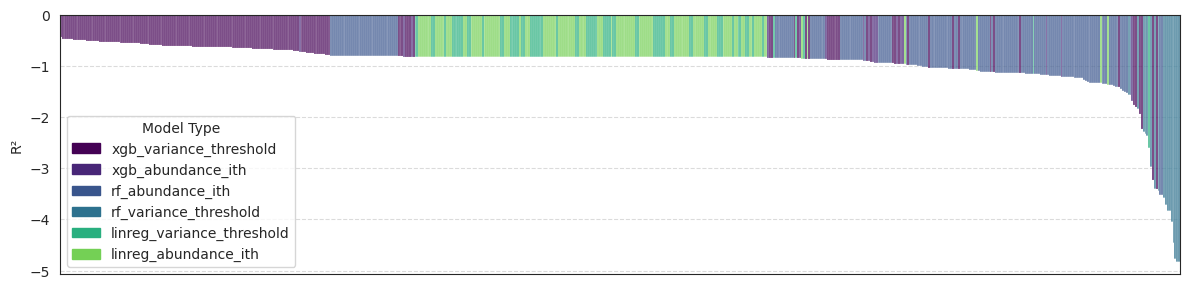

In [94]:
# Define a color palette for each model
model_colors = {'xgb_variance_threshold' : "#440154FF" ,
       'xgb_abundance_ith' : "#482677FF" ,
       'rf_abundance_ith' : "#39558CFF",
       'rf_variance_threshold' : "#2D718EFF",
       'linreg_variance_threshold' : "#29AF7FFF",
       'linreg_abundance_ith' : "#74D055FF"}

# Ensure all models have a color, assign a default if not in the list
df_metrics["color"] = df_metrics["data_type"].map(model_colors).fillna("gray")

plt.figure(figsize=(12, 3))
sns.histplot(
    data=df_metrics,
    x=df_metrics.index,
    weights=df_metrics["metrics.r2_val"],
    bins=len(df_metrics),  
    hue=df_metrics["data_type"],
    palette=model_colors,
    element="bars",
    multiple="stack"  
)

plt.xlim(df_metrics.index.min(), df_metrics.index.max())
plt.xlabel("")
plt.ylabel("R²")
plt.xticks([], [])  # Hide x-axis labels
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show legend
handles = [plt.Rectangle((0,0),1,1, color=color) for color in model_colors.values()]
plt.legend(handles, model_colors.keys(), title="Model Type", loc="lower left")

plt.tight_layout()
plt.savefig('/home/lfloerl/cloud/lfloerl/Microterroir/Figures/RITME-test-R2.png', dpi=1000)
plt.show()

/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/lfloerl/.condaenvs/ritme_model/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/lfloerl/.condaenvs/ri

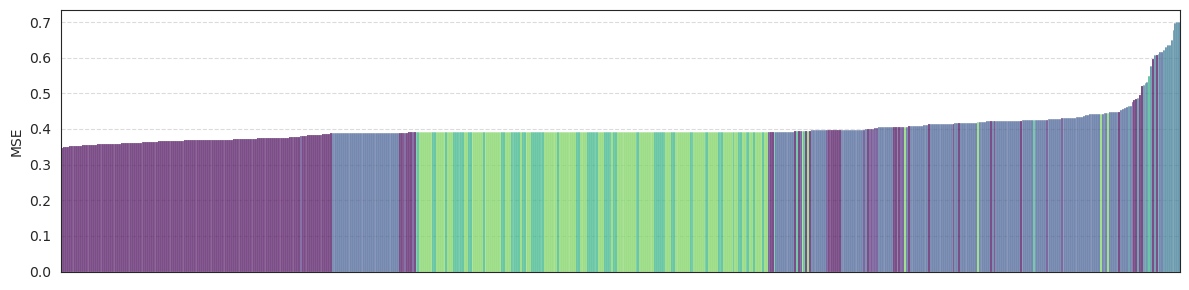

In [95]:
plt.figure(figsize=(12, 3))
sns.histplot(
    data=df_metrics,
    x=df_metrics.index,
    weights=df_metrics["metrics.rmse_val"],
    bins=len(df_metrics),  
    hue=df_metrics["data_type"],
    palette=model_colors,
    element="bars",
    multiple="stack"  
)

plt.xlim(df_metrics.index.min(), df_metrics.index.max())
plt.xlabel("")
plt.ylabel("MSE")
plt.xticks([], [])  # Hide x-axis labels
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.legend([], [], frameon=False)

plt.tight_layout()
plt.savefig('/home/lfloerl/cloud/lfloerl/Microterroir/Figures/RITME-test-MSE.png', dpi=1000)
plt.show()